# ADA PROJECT - Amazon data

Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

<br>

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

>Features:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


>Features:
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



---
### Importing libraries

In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok


%matplotlib inline

In [8]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext
import pyspark.sql.functions as sqlf

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<br>



---
# Data collection and preprocessing

<br>

In this part, we will perform the whole data processing.

To simplify what is presented here, we have decided to perform all these steps for each category in **separate pyton scripts**.

<br>

For each category, we will proceed as follows:
- Import the meta data and reviews that have been downloaded as `json` files
- Extract the relevant and writtable features of meta data
- Save it as a parquet file of the form **`\"category\"_datacleaned`**
- We then do the same with the reviews and save a parquet file of the form **`"category\"_reviews`**
- Next, we **filter the data we have to only keep articles related to ecology/bio/renewable etc...**
- Finally, we join the metadata and review dataset using the product ID, and create a finale parquet file of the form **`\"category\"_review_product_join`**

<br>

Therefore, all you need to do now is execute all the scripts to automatically generate all the parquet files that will be used in tis notebook.

>Note that once these files have been created, we can skip this part to gain a lot of time.

<br>

**Grocery and Gourmet Food**

In [3]:
%run -i "data_collection_grocery_food"
# Run the # Run the data_collection_grocery_food.py file .py file 

**Healthcare**

In [14]:
%run -i "data_collection_healthcare"

**Patio Lawn and Garden**

In [5]:
%run -i "data_collection_lawn_garden"

**Books**

In [ ]:
%run -i "data_collection_books"

**Home and Kitchen**

In [5]:
%run -i "data_collection_home_kitchen"

---
### Useful Data / Functions

In [16]:
nltk.download('stopwords')
set_stopwords =set(stopwords.words('english'))
punctuation = ['.',',','!','?','(',')','-',"'ll","'s","'","'re",'"']
detokenizer = Detok()
#any(word in word2.lower() for word2 in wordsFiltered for word in keywords)

In [1]:
def remove_stopwords(text):
    words = word_tokenize(text)
    wordsFiltered = []
    
    for w in words:
        if((w not in set_stopwords) and (w not in punctuation) ):
            wordsFiltered.append(w)
    text = detokenizer.detokenize(wordsFiltered)
    
    return text

In [9]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle ", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

<br>

---
# Loading data
<br>

Now that our scripts have generated the files, let's just fetch the data that will allow us to do our analysis.

<br>

**Grocery and Gourmet Food**

In [10]:
grocery_food_datacleaned = spark.read.parquet("meta_Grocery_and_Gourmet_Food.parquet")
grocery_food_reviews = spark.read.parquet("reviews_Grocery_and_Gourmet_Food.parquet")
grocery_food_review_product_join = spark.read.parquet("Grocery_and_Gourmet_Food.parquet")

In [11]:
grocery_filter_products_bio = grocery_food_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Healthcare**

In [12]:
healthcare_datacleaned = spark.read.parquet("meta_HealthPersonalCare.parquet")
healthcare_reviews = spark.read.parquet("reviews_HealthPersonalCare.parquet")
healthcare_review_product_join = spark.read.parquet("HealthPersonalCare_joined.parquet")

In [13]:
healthcare_filter_products_bio = healthcare_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Patio Lawn and Garden**

In [14]:
patiolawn_garden_datacleaned = spark.read.parquet("meta_PatioLawnGarden.parquet")
patiolawn_garden_reviews = spark.read.parquet("reviews_PatioLawnGarden.parquet")
patiolawn_garden_review_product_join = spark.read.parquet("PatioLawnGarden_joined.parquet")

In [15]:
patiolawn_garden_filter_products_bio = patiolawn_garden_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Books**

In [ ]:
books_datacleaned = spark.read.parquet("meta_Books.parquet")
books_reviews = spark.read.parquet("reviews_Books.parquet")
books_review_product_join = spark.read.parquet("joined_Books.parquet")

In [ ]:
books_filter_products_bio = books_datacleaned.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Home and Kitchen**

In [16]:
home_datacleaned = spark.read.parquet("meta_HomeKitchen.parquet")
home_reviews = spark.read.parquet("reviews_Home_and_Kitchen.parquet")
home_review_product_join = spark.read.parquet("Home_and_Kitchen_joined.parquet")

In [17]:
home_filter_eco = home_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

<br>

---
# Analysis

<br>

Now let's start analyzing the data we extracted above.

We will carry out different analyses, and each time apply it to all the categories studied to compare them with each other.

<br>

######  **1)** Proportion of ecofriendly products <a href='#section1'>Go to Part 1</a>
First, we will compute and visualize **the proportion of environmentally friendly products in each category**. This will allow us to quickly realize the importance of these products in a category. 

This analysis is also important because we have large differences in quantities between the different categories, which could influence the following analyses.

<br>

######  **2)** Distribution of new products over the years <a href='#section2'>Go to Part 2</a>
Then, we will extract the publication dates of each article in each category to **plot the evolution of the number of eco-friendly products**. With these curves, we will then really be able to observe the evolution of the green trend over time.

Of course, we can a priori suspect that we will obtain increasing curves, but it is interesting to evaluate this growth and compare it from one product category to another.

<br>

######  **3)** Reviews Analysis : Distribution and helpfulness <a href='#section3'>Go to Part 3</a>
Another analysis that we will carry out focuses on the comments left on each of the products. We will indeed track **the distribution of the number of comments by product**. In this way, we can assess people's interest in environmentally friendly products and compare this interest across categories.

<br>

######  **4)** Price Analysis : Evolution and comparison <a href='#section4'>Go to Part 4</a>
Then, we will look at the **average prices of the products in a category, and their evolution over time**. In this way, we will be able to observe the price difference between eco-friendly and other products, and to observe the evolution of this difference over time.

<br>

######  **5)** Rating Analysis <a href='#section5'>Go to Part 5</a>
In this part we will **analyze the products rating given by the reviewers** and compare the outcomes between the ecofriendly or general products, and between the different categories.

<br>

######  **6)** Correlation <a href='#section6'>Go to Part 6</a>
This part will produces an analysis to know if there is a **correlation between the features** regarding the number of reviews, the overall rating, the salesRank position and publishing year of each products. 

<br>

######  **7)** Top Ecofriendly Product  : Comparison with equivalent features <a href='#section7'>Go to Part 7</a>
This part will do a study case for one specific category : Patio Lawn and Garden. We will extract **the best ecofriendly product** based on his salesrank, and observe the similiarities or differences with the same kind of product. In a second part, we'll analyze the products from the same **K-means cluster popularity**.

<br>

######  **8)** Top Ecofriendly Brands <a href='#section8'>Go to Part 8</a>
Then we will analyze and output for each categories the **10 most important brands** based on the popularity of their ecofriendly products.

<br>

######  **9)** Mr/Mrs Ecofriendly <a href='#section9'>Go to Part 9</a>
This interesting analysis will present the winners of our study : the reviewers who bought the largest number of ecofriendly products over all categories.

---
<a id='section1'></a>
## **1) Proportion of ecofriendly products in each category**

In this part we will see the proportion of ecofriendly products among each categories and compare the amount between them.

<br>

**Grocery and Gourmet Food**

In [103]:
nb_allproducts_grocery = grocery_food_datacleaned.rdd.count()
print("GROCERY FOOD : Number of products : " + str(nb_allproducts_grocery) )
nb_bioproducts_grocery = grocery_filter_products_bio.count()
print("GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : " + str(nb_bioproducts_grocery) )

GROCERY FOOD : Number of products : 145854
GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : 2187


Let's take a look at one entry that was extracted:

In [21]:
grocery_filter_products_bio.take(1)

[Row(asin='B001EO602S', brand=None, category='Grocery & Gourmet Food', description='The CO2 process delivers a natural, de-caffeinated tea in the purest way possible. Carbon dioxide, acting as a solvent in a super critical state under high-pressure and low temperature, dissolves all active components from natural materials in the leaf. By varying the extraction/separation pressures and temperatures, CO2 makes it possible to selectively extract only the caffeine, leaving the flavor intact. As a solvent, carbon dioxide is non-toxic, odorless, tasteless, germicidal, food-safe and non-combustible and the process does not cause environmental harm.', price=None, salesRank=267957, title='SerendipiTea De-Caff Slim Mint, Chocolate, Vanilla, Rooiboos, Mint &amp; Organic Black Tea, 4-Ounce Boxes (Pack of 2)')]

We can observe that the extracted sample is indeed representing an ecofriendly product, by looking at the description : *'does not cause environmental harm'*.

<br>

**Healthcare**

In [86]:
nb_allproducts_healthcare = healthcare_datacleaned.rdd.count()
print("HEALTHCARE : Number of products : " + str(nb_allproducts_healthcare) )
nb_bioproducts_healthcare = healthcare_filter_products_bio.count()
print("HEALTHCARE : Number of products related to ecology/bio/renewable etc... : " + str(nb_bioproducts_healthcare) )

HEALTHCARE : Number of products : 217977
HEALTHCARE : Number of products related to ecology/bio/renewable etc... : 5390


<br>

**Patio Lawn and Garden**

In [128]:
nb_allproducts_garden = patiolawn_garden_datacleaned.rdd.count()
print("PATIOLAWN - GARDEN : Number of products : " + str(nb_allproducts_garden) )
nb_bioproducts_garden = patiolawn_garden_filter_products_bio.count()
print("PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : " + str(nb_bioproducts_garden) )

PATIOLAWN - GARDEN : Number of products : 83455
PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : 3026


<br>

**Books**

In [ ]:
nb_allproducts_books = books_datacleaned.rdd.count()
print("BOOKS : Number of products : " + str(nb_allproducts_books) )
nb_bio_products = books_filter_products_bio.count()
print("BOOKS : Number of products related to ecology/bio/renewable etc... : " + str(nb_bio_products) )

**Home and Kitchen**

In [129]:
nb_allproducts_home = home_datacleaned.rdd.count()
print("BOOKS : Number of products : " + str(nb_allproducts_home) )
nb_bioproducts_home = home_filter_eco.count()
print("BOOKS : Number of products related to ecology/bio/renewable etc... : " + str(nb_bioproducts_home) )

BOOKS : Number of products : 336805
BOOKS : Number of products related to ecology/bio/renewable etc... : 7470


We can see the number of products is different of the categories. Indeed there is for example approximately 80.000 products in the Garden category, whereas in the Home & Kitchen category there is more than 300.000 products. 
But as we are studying the ecofriendly products, we are way more interested in the proportion of ecofriendly products against the general products of a given category. That is what we will show below.

Proportion of extracted data related to ecology/bio/renewable compared to the full data that was available:

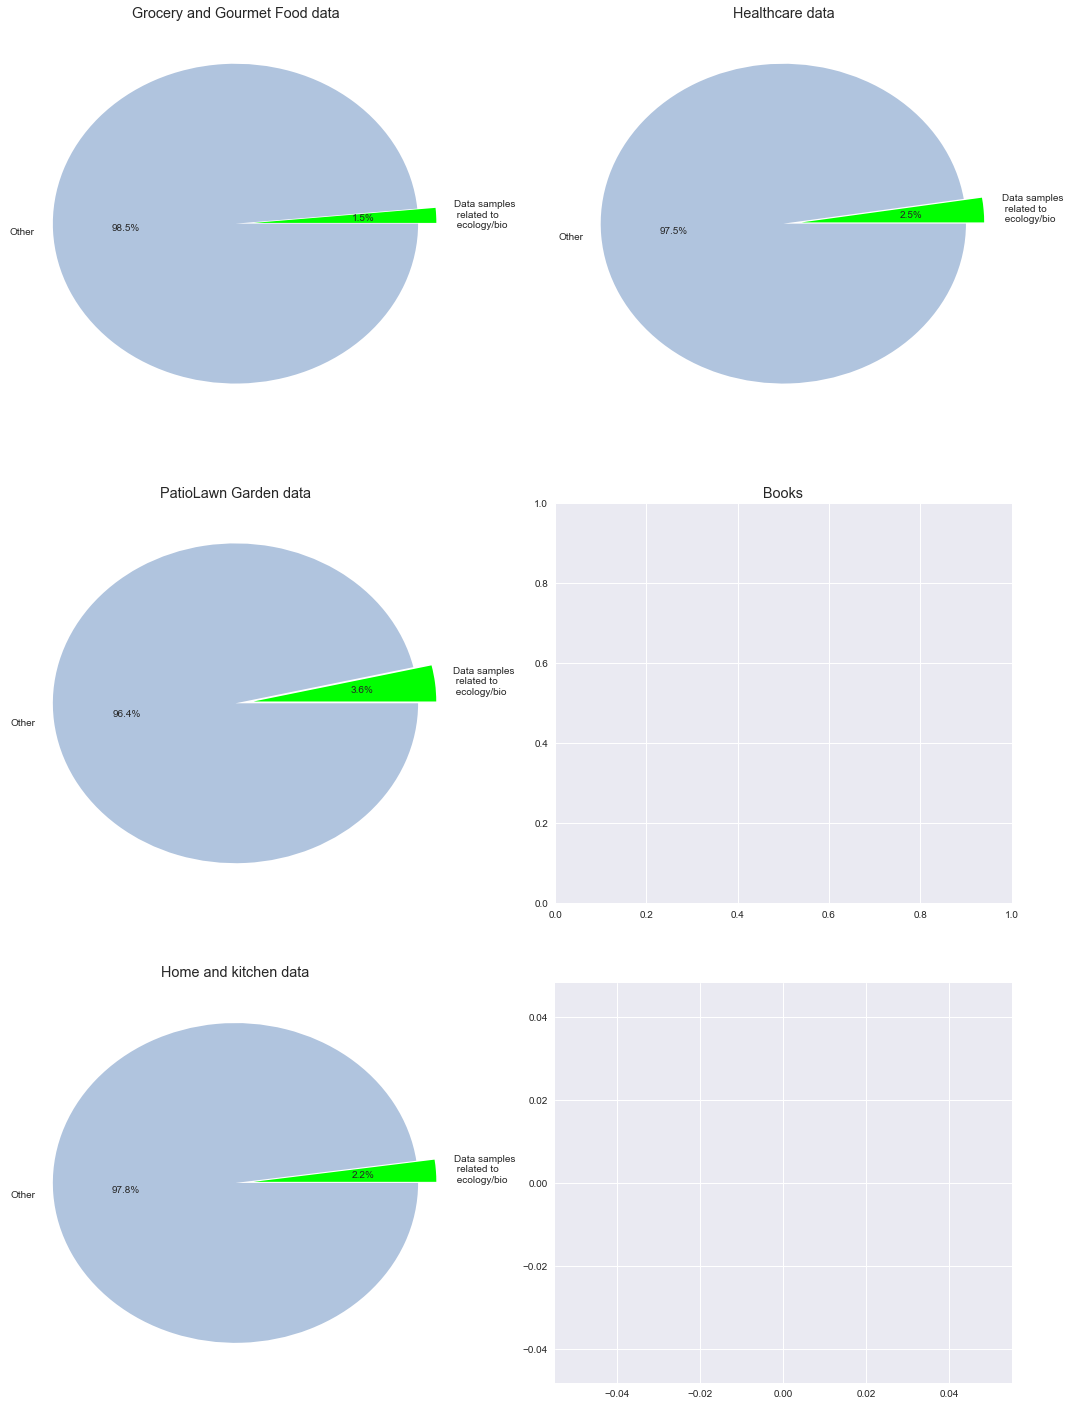

In [134]:
fig, axes = plt.subplots(3,2)
fig.set_size_inches(18,25)

labels = 'Data samples\n related to\n ecology/bio', 'Other'; colors_graph = ['lime', 'lightsteelblue']

axes[0,0].pie([nb_bioproducts_grocery, nb_allproducts_grocery-nb_bioproducts_grocery], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
axes[0,0].set_title('Grocery and Gourmet Food data', fontsize='x-large')

axes[0,1].pie([nb_bioproducts_healthcare, nb_allproducts_healthcare-nb_bioproducts_healthcare], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
axes[0,1].set_title('Healthcare data', fontsize='x-large'); plt.axis('equal')

axes[1,0].pie([nb_bioproducts_garden, nb_allproducts_garden-nb_bioproducts_garden], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
axes[1,0].set_title('PatioLawn Garden data', fontsize='x-large')

# PUT BOOK here
#axes[1,1].pie([nb_bioproducts_books, nb_allproducts_books-nb_bioproducts_books], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
axes[1,1].set_title('Books', fontsize='x-large'); 

axes[2,0].pie([nb_bioproducts_home, nb_allproducts_home-nb_bioproducts_home], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
axes[2,0].set_title('Home and kitchen data', fontsize='x-large'); 



plt.show()

We can observe on these pie plots, that the proportion is between 1% and 3.6% for each category. There is obviously a huge amount of products not concerned by the environmental aspects.
The more represented category is the Garden. Indeed this could be explained by the fact that the Garden articles are used outside, and shall have a more specific attention on the toxical/environmental aspects. 

---
<a id='section2'></a>
## **2) Evolution of the number of eco-friendly products by year.**



Indeed that is something that interest us. The number of eco-friendly item released per year can be a relevant source of information concerning the supply and demand.
But we are also aware not to draw to quick conclusion. We are actually working with Amazon's datasets. Amazon was founded in 1994 and since is in full growth. Although we are expected some special trend or increase of eco-friendly products, we stay aware that there is also a global increase of proposal products.

Futhermore, the awareness in climate change (or the real involvement in it) is something quite recent can be toughly observable in some categories or behavior.

**How we proceed :**
- For each category belown, we groupby the product by the id and keep only the minimum time review which correspond to the first review. Then we convert this time in year and assign it as the released year of the product. We do the process for all filtered eco-friendly products and also for all of them in order to see the difference.

- Then we compute the proportion in percentage (%) of products per year, to plot a second histogram allowing the comparison of proportion between ecofriendly and general products. 

- Finally, for each category we train a small Linear regression model with a degree equals to 5, in order to get the function curve representing the evolution of products per year. 

Indeed, the collection of this dataset stopped before July 2014, hence the data is not complete for this year. The information and the number of products for 2014 must not be misinterpreted, that is why we computed a predicted value for 2014 for each category.
Then, in the plot representing the correct proportion of products per year with percentages, we added the bars values predicted by the model. However, the predictions are not scaled and will only give an overview of the evolution shape in the plot.



<br>

**Grocery and Gourmet Food**

In [135]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
grocerybio_firstrev = grocery_food_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
grocerybio_firstrev_pd = grocerybio_firstrev.toPandas()
grocerybio_firstrev_pd['Year'] = pd.to_datetime(grocerybio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

# Compute and aggregate first review --> publication year of the product : All products
groceryall_firstrev = grocery_food_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
groceryall_firstrev_pd = groceryall_firstrev.toPandas()
groceryall_firstrev_pd['Year'] = pd.to_datetime(groceryall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [136]:
#Compute Histogram of ecofriendly products publication years
grocerybio_firstrev_index = np.sort(grocerybio_firstrev_pd['Year'].unique())
grocerybio_firstrev_histogram,_ = np.histogram(grocerybio_firstrev_pd['Year'], len(grocerybio_firstrev_index), density=True)

grocerybio_firstrev_serie = pd.Series(grocerybio_firstrev_histogram, index=grocerybio_firstrev_index)*100
grocerybio_firstrev_serie = grocerybio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
groceryeall_firstrev_index = np.sort(groceryall_firstrev_pd['Year'].unique())
groceryall_firstrev_histogram,_ = np.histogram(groceryall_firstrev_pd['Year'], len(groceryeall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
grocery_firstrev_histogram = pd.DataFrame(groceryall_firstrev_histogram, index=groceryeall_firstrev_index, columns=['All Products']) *100  
grocery_firstrev_histogram['Ecofriendly products'] = grocerybio_firstrev_serie
grocery_firstrev_histogram = grocery_firstrev_histogram.fillna(0)

In [137]:
# Compute predicted model for 2014
X_grocery = np.array(grocery_firstrev_histogram.index)
X_grocery = X_grocery.reshape(-1,1)
X_grocery_train = X_grocery[0:-1]

y_grocery = np.array(grocery_firstrev_histogram['All Products'])
y_grocery = y_grocery.reshape(-1,1)
y_grocery_train = y_grocery[0:-1]

model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X_grocery_train, y_grocery_train)
predicted_grocery = model.predict(X_grocery)
predicted_grocery = predicted_grocery.reshape(-1,)
X_grocery = X_grocery.reshape(-1,)
predicted_grocery_series = pd.Series(predicted_grocery, index=X_grocery)

Text(0.5,1,'Grocery : Histogram, Number of products first published per year (log scale)')

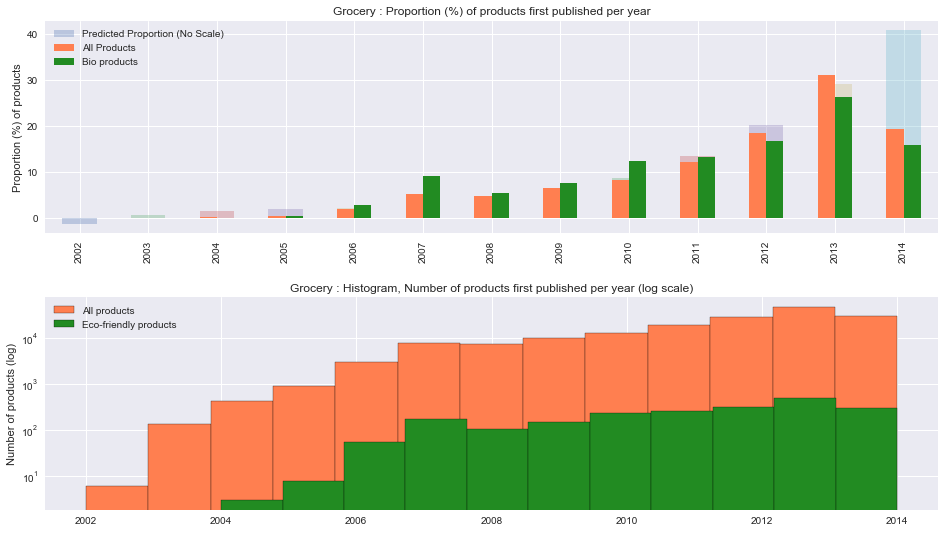

In [146]:
# Plot
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,9)

# Plot predicted proportion
ax1 = predicted_grocery_series.plot(kind='bar', alpha=0.3,ax=axes[0])
# Plot computed proportion of products/year
grocery_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=ax1)
ax1.legend(['Predicted Proportion (No Scale)','All Products','Bio products'])
ax1.set_title("Grocery : Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")

# Plot log histogram of products/year
ax2 = groceryall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black',bins=13,ax=axes[1])
grocerybio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black',log=True,bins=11,ax = ax2)
plt.legend(['All products',"Eco-friendly products"])
plt.ylabel("Number of products (log)")
plt.title('Grocery : Histogram, Number of products first published per year (log scale)')

<br>

**Healthcare**

In [29]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
healthcarebio_firstrev = healthcare_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcarebio_firstrev_pd = healthcarebio_firstrev.toPandas()
healthcarebio_firstrev_pd['Year'] = pd.to_datetime(healthcarebio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcarebio_firstrev_pd = healthcarebio_firstrev_pd.drop('min(unixReviewTime)', axis=1)


# Compute and aggregate first review --> publication year of the product : All products
healthcareall_firstrev = healthcare_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcareall_firstrev_pd = healthcareall_firstrev.toPandas()
healthcareall_firstrev_pd['Year'] = pd.to_datetime(healthcareall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcareall_firstrev_pd = healthcareall_firstrev_pd.drop('min(unixReviewTime)', axis=1)

In [30]:
#Compute Histogram of ecofriendly products publication years
healthcarebio_firstrev_index = np.sort(healthcarebio_firstrev_pd['Year'].unique())
healthcarebio_firstrev_histogram,_ = np.histogram(healthcarebio_firstrev_pd['Year'], len(healthcarebio_firstrev_index), density=True)

healthcarebio_firstrev_serie = pd.Series(healthcarebio_firstrev_histogram, index=healthcarebio_firstrev_index)*100
healthcarebio_firstrev_serie = healthcarebio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
healthcareall_firstrev_index = np.sort(healthcareall_firstrev_pd['Year'].unique())
healthcareall_firstrev_histogram,_ = np.histogram(healthcareall_firstrev_pd['Year'], len(healthcareall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
healthcare_firstrev_histogram = pd.DataFrame(healthcareall_firstrev_histogram, index=healthcareall_firstrev_index, columns=['All Products']) *100  
healthcare_firstrev_histogram['Ecofriendly products'] = healthcarebio_firstrev_serie
healthcare_firstrev_histogram = healthcare_firstrev_histogram.fillna(0)

In [532]:
# Compute predicted model for 2014
X_healthcare = np.array(healthcare_firstrev_histogram.index)
X_healthcare = X_healthcare.reshape(-1,1)
X_healthcare_train = X_healthcare[0:-1]

y_healthcare = np.array(healthcare_firstrev_histogram['All Products'])
y_healthcare = y_healthcare.reshape(-1,1)
y_healthcare_train = y_healthcare[0:-1]

model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X_healthcare_train, y_healthcare_train)
predicted_healthcare = model.predict(X_healthcare)
predicted_healthcare = predicted_healthcare.reshape(-1,)
X_healthcare = X_healthcare.reshape(-1,)
predicted_healthcare_series = pd.Series(predicted_healthcare, index=X_healthcare)

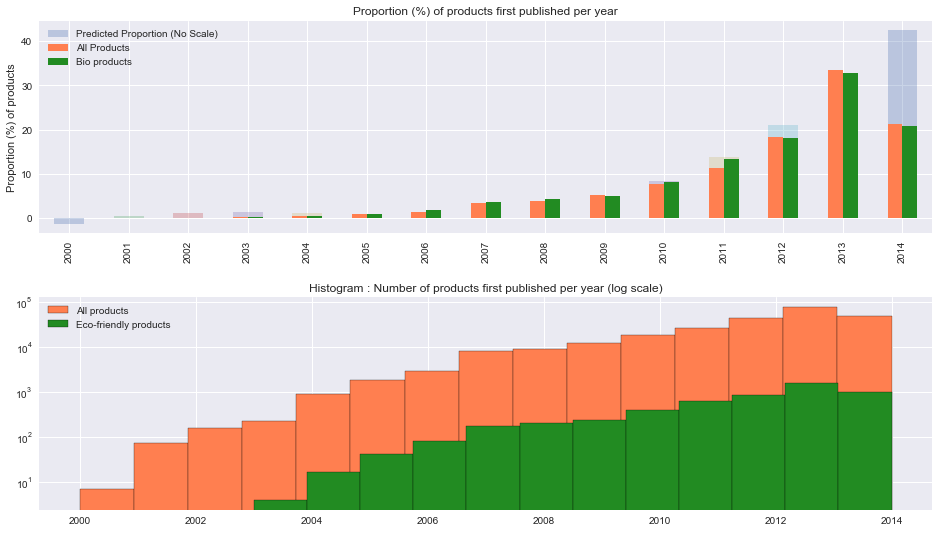

In [552]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,9)


ax1 = predicted_healthcare_series.plot(kind='bar', alpha=0.3,ax=axes[0])
healthcare_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=ax1)
ax1.legend(['Predicted Proportion (No Scale)','All Products','Bio products'])

ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")

ax2 = healthcareall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black',bins=15, ax=axes[1])
healthcarebio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black', log=True,bins=12,ax=ax2)

plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')
plt.show()

<br>

**PatioLawn Garden**

In [19]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
gardenbio_firstrev = patiolawn_garden_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardenbio_firstrev_pd = gardenbio_firstrev.toPandas()
gardenbio_firstrev_pd['Year'] = pd.to_datetime(gardenbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
gardenbio_firstrev_pd = gardenbio_firstrev_pd.drop('min(unixReviewTime)', axis=1)


# Compute and aggregate first review --> publication year of the product : All products
gardeneall_firstrev = patiolawn_garden_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardeneall_firstrev_pd = gardeneall_firstrev.toPandas()
gardeneall_firstrev_pd['Year'] = pd.to_datetime(gardeneall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
gardeneall_firstrev_pd = gardeneall_firstrev_pd.drop(['min(unixReviewTime)'], axis=1)

In [42]:
#Compute Histogram of ecofriendly products publication years
gardenbio_firstrev_index = np.sort(gardenbio_firstrev_pd['Year'].unique())
gardenbio_firstrev_histogram,_ = np.histogram(gardenbio_firstrev_pd['Year'], len(gardenbio_firstrev_index), density=True)

gardenbio_firstrev_serie = pd.Series(gardenbio_firstrev_histogram, index=gardenbio_firstrev_index)*100
gardenbio_firstrev_serie = gardenbio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
gardenall_firstrev_index = np.sort(gardeneall_firstrev_pd['Year'].unique())
gardenall_firstrev_histogram,_ = np.histogram(gardeneall_firstrev_pd['Year'], len(gardenall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
garden_firstrev_histogram = pd.DataFrame(gardenall_firstrev_histogram, index=gardenall_firstrev_index, columns=['All Products']) *100  
garden_firstrev_histogram['Ecofriendly products'] = gardenbio_firstrev_serie
garden_firstrev_histogram = garden_firstrev_histogram.fillna(0)

In [539]:
# Compute predicted model for 2014
X_garden = np.array(garden_firstrev_histogram.index)
X_garden = X_garden.reshape(-1,1)
X_garden_train = X_garden[0:-1]

y_garden = np.array(garden_firstrev_histogram['All Products'])
y_garden = y_garden.reshape(-1,1)
y_garden_train = y_garden[0:-1]

model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X_garden_train, y_garden_train)
predicted_garden = model.predict(X_garden)
predicted_garden = predicted_garden.reshape(-1,)
X_garden = X_garden.reshape(-1,)
predicted_garden_series = pd.Series(predicted_garden, index=X_garden)

Text(0.5,1,'Histogram : Number of products first published per year (log scale)')

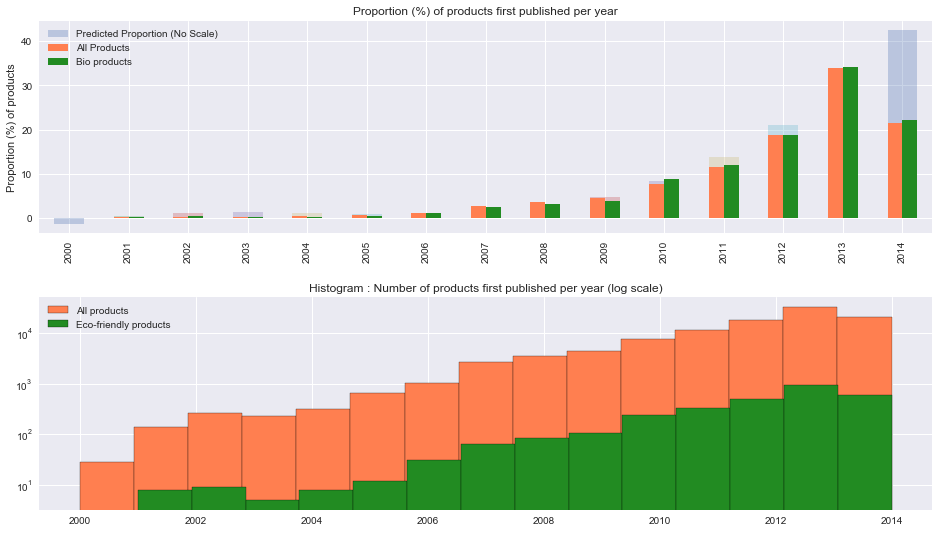

In [546]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,9)

ax1 = predicted_healthcare_series.plot(kind='bar', alpha=0.3,ax=axes[0])
garden_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=ax1)
ax1.legend(['Predicted Proportion (No Scale)','All Products','Bio products'])


ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")

ax2 = gardeneall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black', bins=15, ax=axes[1])
gardenbio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black', log=True,bins=14,ax=ax2)

plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')

<br>

**Books**

In [ ]:
booksbio_firstrev = books_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksbio_firstrev_pd = booksbio_firstrev.toPandas()
booksbio_firstrev_pd['Year'] = pd.to_datetime(booksbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

booksall_firstrev = books_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksall_firstrev_pd = booksall_firstrev.toPandas()
booksall_firstrev_pd['Year'] = pd.to_datetime(booksall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [ ]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(16,4)

ax = booksall_firstrev_pd.hist("Year", log=True, color="coral", bins=18, ax=axes)
booksbio_firstrev_pd.hist("Year", color="green", log=True,bins=17,ax=ax)

plt.title('Number of products per year (log scale)')
axes.legend(['All products',"Eco-friendly products"])

plt.show()

**Home and Kitchen**

In [52]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
homebio_firstrev = home_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
homebio_firstrev_pd = homebio_firstrev.toPandas()
homebio_firstrev_pd['Year'] = pd.to_datetime(homebio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

# Compute and aggregate first review --> publication year of the product : All products
homeall_firstrev = home_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
homeall_firstrev_pd = homeall_firstrev.toPandas()
homeall_firstrev_pd['Year'] = pd.to_datetime(homeall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [53]:
#Compute Histogram of ecofriendly products publication years
homebio_firstrev_index = np.sort(homebio_firstrev_pd['Year'].unique())
homebio_firstrev_histogram,_ = np.histogram(homebio_firstrev_pd['Year'], len(homebio_firstrev_index), density=True)

homebio_firstrev_serie = pd.Series(homebio_firstrev_histogram, index=homebio_firstrev_index)*100
homebio_firstrev_serie = homebio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
homeall_firstrev_index = np.sort(homeall_firstrev_pd['Year'].unique())
homeall_firstrev_histogram,_ = np.histogram(homeall_firstrev_pd['Year'], len(homeall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
home_firstrev_histogram = pd.DataFrame(homeall_firstrev_histogram, index=homeall_firstrev_index, columns=['All Products']) *100  
home_firstrev_histogram['Ecofriendly products'] = homebio_firstrev_serie
home_firstrev_histogram = home_firstrev_histogram.fillna(0)

In [543]:
# Compute predicted model for 2014
X_home = np.array(home_firstrev_histogram.index)
X_home = X_home.reshape(-1,1)
X_home_train = X_home[0:-1]

y_home = np.array(home_firstrev_histogram['All Products'])
y_home = y_home.reshape(-1,1)
y_home_train = y_home[0:-1]

model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X_home_train, y_home_train)
predicted_home = model.predict(X_home)
predicted_home = predicted_home.reshape(-1,)
X_home = X_home.reshape(-1,)
predicted_home_series = pd.Series(predicted_home, index=X_home)

Text(0.5,1,'Histogram : Number of products first published per year (log scale)')

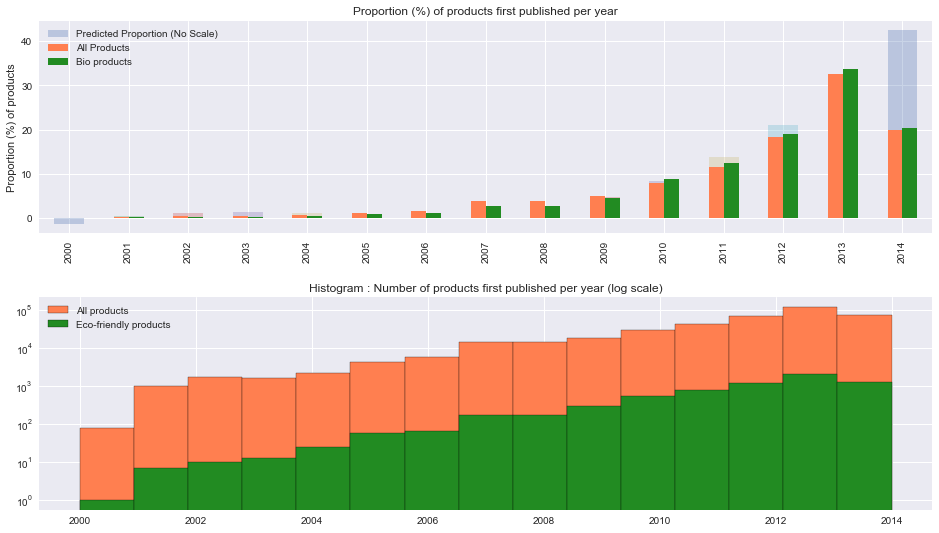

In [550]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,9)

ax1 = predicted_healthcare_series.plot(kind='bar', alpha=0.3,ax=axes[0])
home_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=ax1)
ax1.legend(['Predicted Proportion (No Scale)','All Products','Bio products'])


ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")


ax2 = homeall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black', bins=15, ax=axes[1])
homebio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black',log=True,bins=15,ax=ax2)

plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')

**Analysis**

As we can see, for every categories, the number of products published is quite under the estimation for the year 2014. Actually we are thinking about two reasons that can explain those differences. First because of a crisis or a US tax law that have been created. The second option, which might be the real reason, is that our dataset does not contain all the year 2014.

Quote : "This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014." 
from http://jmcauley.ucsd.edu/data/amazon/links.html

---
<a id='section3'></a>
## **3) Distribution of the number of comments by product**


Now we are goin to interest in the reviews distribution over the eco-friendly items in order to find a relevant trend or behavior in those items.
For each product, we count by id the number of reviews received and the frequency of it. This is also an indicator of how much can people be interested in.

In [285]:
def compute_helpful_proportion(dataframe):
    sum_helpful = np.sum(dataframe['freq'])
    dataframe['freq'] = dataframe['freq'].divide(sum_helpful)
    mean_helpful = 0
    for i in range(len(dataframe)):
        mean_helpful = mean_helpful + float(dataframe.iloc[i]['helpful'])*float(dataframe.iloc[i]['freq'])
    
    return  dataframe['freq']*100, mean_helpful

In [316]:
def custom_round(val):
    return (np.ceil(val * 10)/10)

def compute_helpful(positive, total):
    if(total == 0):
        res = -1
    else:
        res = positive/total
        res = custom_round(res)
    return str(res)

<br>

**Grocery Food**

Compute histogram of reviews

In [289]:
# Histogram of reviews for ecofriendly products
grocerybio_nbrev_perproduct=  grocery_food_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

grocerybio_nbreviews_DF = spark.createDataFrame(grocerybio_nbrev_perproduct, ['productID','freq'])
grocerybio_nbreviews_Pandas = grocerybio_nbreviews_DF.toPandas()

In [290]:
# Histogram of reviews for all products
groceryall_nbrev_perproduct=  grocery_food_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

groceryall_nbreviews_DF = spark.createDataFrame(groceryall_nbrev_perproduct, ['productID','freq'])
groceryall_nbreviews_pd = groceryall_nbreviews_DF.toPandas()

Compute proportion of helpfulness per comment

In [304]:
# Proportion helpfulness for ecofriendly products
grocerybio_helpful =  grocery_food_review_product_join.rdd.filter(lambda r: (r[7][0]>3))\
            .map(lambda r: [compute_helpful(r[7][0],r[7][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

grocerybio_helpful_df = spark.createDataFrame(grocerybio_helpful)
grocerybio_helpful_pd = grocerybio_helpful_df.toPandas()
grocerybio_helpful_pd.columns = ['helpful','freq']
grocerybio_helpful_pd = grocerybio_helpful_pd.sort_values('helpful')

grocerybio_helpful_pd['freq'], grocerybio_mean_helpful = compute_helpful_proportion(grocerybio_helpful_pd)
grocerybio_helpful_pd = grocerybio_helpful_pd.set_index('helpful')

In [305]:
# Proportion helpfulness for all products
groceryall_helpful =  grocery_food_reviews.rdd.filter(lambda r: (r[1][0]>3))\
            .map(lambda r: [compute_helpful(r[1][0],r[1][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

groceryall_helpful_df = spark.createDataFrame(groceryall_helpful)
groceryall_helpful_pd = groceryall_helpful_df.toPandas()
groceryall_helpful_pd.columns = ['helpful','freq']
groceryall_helpful_pd = groceryall_helpful_pd.sort_values('helpful')

groceryall_helpful_pd['freq'], groceryall_mean_helpful = compute_helpful_proportion(groceryall_helpful_pd)
groceryall_helpful_pd = groceryall_helpful_pd.set_index('helpful')

In [306]:
# Merge ecofriendly and all products for helpfulness of reviews
groceryall_helpful_pd['All products'] = groceryall_helpful_pd['freq']
groceryall_helpful_pd['Ecofriendly products'] = grocerybio_helpful_pd['freq']
groceryall_helpful_pd = groceryall_helpful_pd.drop('freq',axis=1)

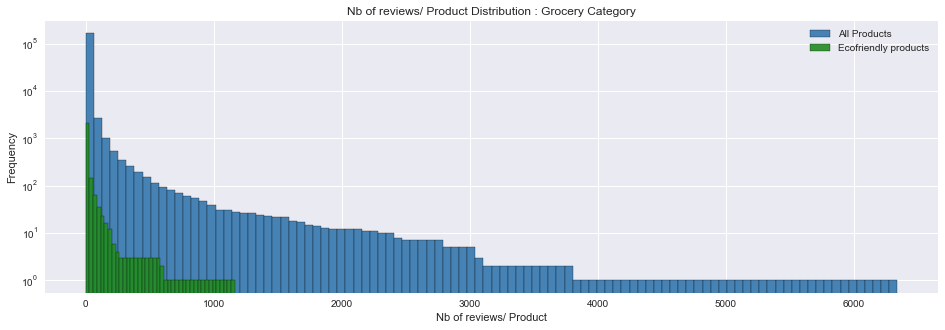

In [303]:
# Plot histogram of reviews
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

ax = groceryall_nbreviews_pd.hist(log=True, bins = 100, color="steelblue",edgecolor='black', cumulative=-1, ax=axes)

grocerybio_nbreviews_Pandas.hist(log=True, bins = 40, color="forestgreen",edgecolor='black',alpha=0.9, cumulative=-1, ax=ax)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution : Grocery Category")

plt.legend(['All Products','Ecofriendly products'])

Text(0.5,1,'Proportion of helpfulness rate of all reviews : Grocery category')

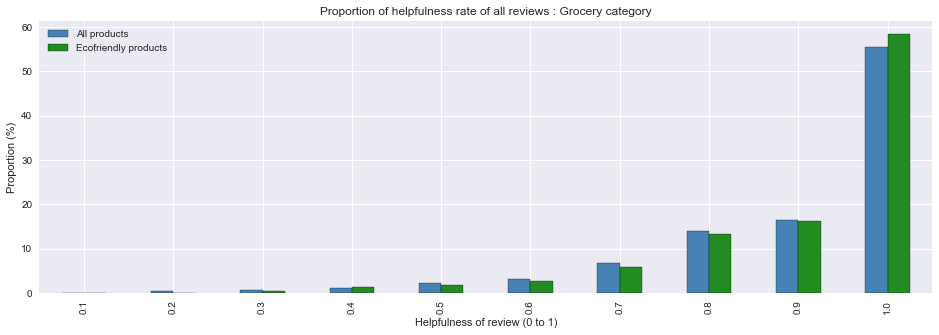

In [307]:
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

groceryall_helpful_pd.plot(kind='bar', color=["steelblue","forestgreen"], edgecolor='black',ax = axes)
axes.set_xlabel("Helpfulness of review (0 to 1)")
axes.set_ylabel("Proportion (%)")
axes.set_title("Proportion of helpfulness rate of all reviews : Grocery category")

In [310]:
grocerybio_review_perproduct = np.sum(grocerybio_nbreviews_Pandas['freq'])/len(grocerybio_nbreviews_Pandas)
print("Grocery category : Mean reviews per ecofriendly product : " + str(grocerybio_review_perproduct))
print("Grocery category : Mean helpfulness per review (ecofriendly products) : " + str(grocerybio_mean_helpful))

Grocery category : Mean reviews per ecofriendly product : 10.629716981132075
Grocery category : Mean helpfulness per review (ecofriendly products) : 0.9084566596194503


In [311]:
groceryall_review_perproduct = np.sum(groceryall_nbreviews_pd['freq'])/len(groceryall_nbreviews_pd)
print("Grocery category : Mean reviews per general product : " + str(groceryall_review_perproduct))
print("Grocery category : Mean helpfulness per review (all products) : " + str(groceryall_mean_helpful))

Grocery category : Mean reviews per general product : 7.811886852676017
Grocery category : Mean helpfulness per review (all products) : 0.8976204889406287


<br>

**Healthcare**

Compute histogram of reviews

In [314]:
# Histogram of reviews for ecofriendly products
healthcarebio_nbrev_perproduct=  healthcare_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

healthcarebio_nbreviews_DF = spark.createDataFrame(healthcarebio_nbrev_perproduct, ['productID','freq'])
healthcarebio_nbreviews_pd = healthcarebio_nbreviews_DF.toPandas()

In [312]:
# Histogram of reviews for all products
healthcareall_nbrev_perproduct=  healthcare_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

healthcareall_nbreviews_DF = spark.createDataFrame(healthcareall_nbrev_perproduct, ['productID','freq'])
healthcareall_nbreviews_pd = healthcareall_nbreviews_DF.toPandas()

Compute proportion of helpfulness per comment

In [317]:
# Proportion helpfulness for ecofriendly products
healthcarebio_helpful =  healthcare_review_product_join.rdd.filter(lambda r: (r[7][0]>3))\
            .map(lambda r: [compute_helpful(r[7][0],r[7][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

healthcarebio_helpful_df = spark.createDataFrame(healthcarebio_helpful)
healthcarebio_helpful_pd = healthcarebio_helpful_df.toPandas()
healthcarebio_helpful_pd.columns = ['helpful','freq']
healthcarebio_helpful_pd = healthcarebio_helpful_pd.sort_values('helpful')

healthcarebio_helpful_pd['freq'], healthcarebio_mean_helpful = compute_helpful_proportion(healthcarebio_helpful_pd)
healthcarebio_helpful_pd = healthcarebio_helpful_pd.set_index('helpful')

In [318]:
# Proportion helpfulness for all products
healthcareall_helpful =  healthcare_reviews.rdd.filter(lambda r: (r[1][0]>3))\
            .map(lambda r: [compute_helpful(r[1][0],r[1][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

healthcareall_helpful_df = spark.createDataFrame(healthcareall_helpful)
healthcareall_helpful_pd = healthcareall_helpful_df.toPandas()
healthcareall_helpful_pd.columns = ['helpful','freq']
healthcareall_helpful_pd = healthcareall_helpful_pd.sort_values('helpful')

healthcareall_helpful_pd['freq'], healthcareall_mean_helpful = compute_helpful_proportion(healthcareall_helpful_pd)
healthcareall_helpful_pd = healthcareall_helpful_pd.set_index('helpful')

In [319]:
# Merge ecofriendly and all products for helpfulness of reviews
healthcareall_helpful_pd['All products'] = healthcareall_helpful_pd['freq']
healthcareall_helpful_pd['Ecofriendly products'] = healthcarebio_helpful_pd['freq']
healthcareall_helpful_pd = healthcareall_helpful_pd.drop('freq',axis=1)

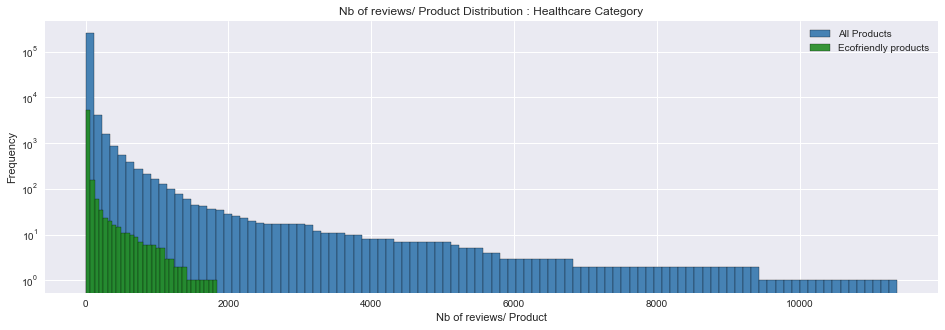

In [320]:
# Plot histogram of reviews
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

ax = healthcareall_nbreviews_pd.hist(log=True, bins = 100, color="steelblue",edgecolor='black', cumulative=-1, ax=axes)

healthcarebio_nbreviews_pd.hist(log=True, bins = 30, color="forestgreen",edgecolor='black',alpha=0.9, cumulative=-1, ax=ax)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution : Healthcare Category")

plt.legend(['All Products','Ecofriendly products'])

Text(0.5,1,'Proportion of helpfulness rate of all reviews : Healthcare category')

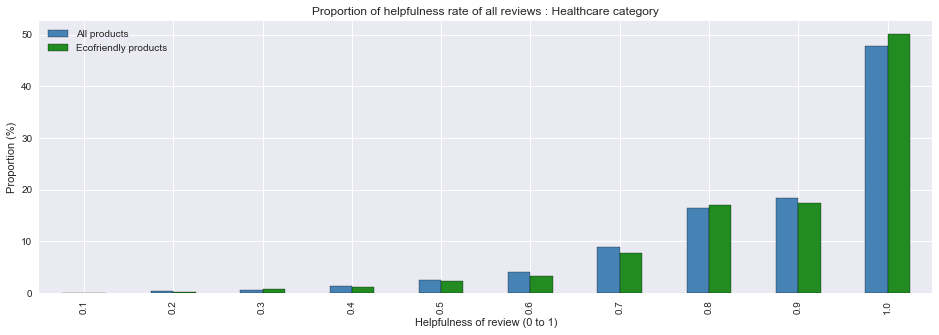

In [321]:
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

healthcareall_helpful_pd.plot(kind='bar', color=["steelblue","forestgreen"], edgecolor='black',ax = axes)
axes.set_xlabel("Helpfulness of review (0 to 1)")
axes.set_ylabel("Proportion (%)")
axes.set_title("Proportion of helpfulness rate of all reviews : Healthcare category")

In [322]:
healthcarebio_review_perproduct = np.sum(healthcarebio_nbreviews_pd['freq'])/len(healthcarebio_nbreviews_pd)
print("Healthcare category : Mean reviews per ecofriendly product : " + str(healthcarebio_review_perproduct))
print("Healthcare category : Mean helpfulness per review (ecofriendly products) : " + str(healthcarebio_mean_helpful))

Garden category : Mean reviews per ecofriendly product : 11.553252734599885
Garden category : Mean helpfulness per review (ecofriendly products) : 0.8870620333141872


In [323]:
healthcareall_review_perproduct = np.sum(healthcareall_nbreviews_pd['freq'])/len(healthcareall_nbreviews_pd)
print("Healthcare category : Mean reviews per general product : " + str(healthcareall_review_perproduct))
print("Healthcare category : Mean helpfulness per review (all products) : " + str(healthcareall_mean_helpful))

Healthcare category : Mean reviews per general product : 11.819102686550602
Healthcare category : Mean helpfulness per review (all products) : 0.879168229440152


<br>

**Patio Lawn Garden**

Compute histogram of reviews

In [55]:
# Histogram of reviews for ecofriendly products
gardenbio_nbrev_perproduct=  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

gardenbio_nbreviews_DF = spark.createDataFrame(gardenbio_nbrev_perproduct, ['productID','freq'])
gardenbio_nbreviews_pd = gardenbio_nbreviews_DF.toPandas()

In [ ]:
# Histogram of reviews for all products
gardenall_nbrev_perproduct=  patiolawn_garden_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

gardenall_nbreviews_DF = spark.createDataFrame(gardenall_nbrev_perproduct, ['productID','freq'])
gardenall_nbreviews_pd = gardenall_nbreviews_DF.toPandas()

Compute proportion of helpfulness per comment

In [284]:
# Proportion helpfulness for ecofriendly products
gardenbio_helpful =  patiolawn_garden_review_product_join.rdd.filter(lambda r: (r[7][0]>3))\
            .map(lambda r: [compute_helpful(r[7][0],r[7][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

gardenbio_helpful_df = spark.createDataFrame(gardenbio_helpful)
gardenbio_helpful_pd = gardenbio_helpful_df.toPandas()
gardenbio_helpful_pd.columns = ['helpful','freq']
gardenbio_helpful_pd = gardenbio_helpful_pd.sort_values('helpful')

gardenbio_helpful_pd['freq'], gardenbio_mean_helpful = compute_helpful_proportion(gardenbio_helpful_pd)
gardenbio_helpful_pd = gardenbio_helpful_pd.set_index('helpful')

In [236]:
# Proportion helpfulness for all products
gardenall_helpful =  patiolawn_garden_reviews.rdd.filter(lambda r: (r[1][0]>3))\
            .map(lambda r: [compute_helpful(r[1][0],r[1][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

gardenall_helpful_df = spark.createDataFrame(gardenall_helpful)
gardenall_helpful_pd = gardenall_helpful_df.toPandas()
gardenall_helpful_pd.columns = ['helpful','freq']
gardenall_helpful_pd = gardenall_helpful_pd.sort_values('helpful')

gardenall_helpful_pd['freq'], gardenall_mean_helpful = compute_helpful_proportion(gardenall_helpful_pd)
gardenall_helpful_pd = gardenall_helpful_pd.set_index('helpful')

In [238]:
# Merge ecofriendly and all products for helpfulness of reviews
gardenall_helpful_pd['All products'] = gardenall_helpful_pd['freq']
gardenall_helpful_pd['Ecofriendly products'] = gardenbio_helpful_pd['freq']
gardenall_helpful_pd = gardenall_helpful_pd.drop('freq',axis=1)

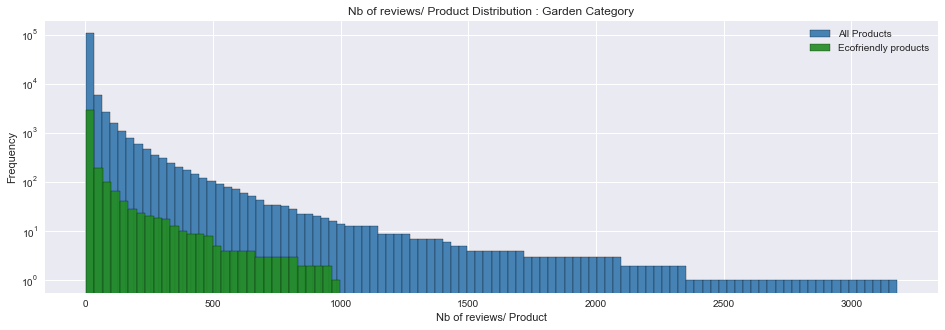

In [239]:
# Plot histogram of reviews
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)

ax = gardenall_nbreviews_pd.hist(log=True, bins = 100, color="steelblue",edgecolor='black', cumulative=-1, ax=axes)

gardenbio_nbreviews_pd.hist(log=True, bins = 30, color="forestgreen",edgecolor='black',alpha=0.9, cumulative=-1, ax=ax)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution : Garden Category")

plt.legend(['All Products','Ecofriendly products'])

Text(0.5,1,'Proportion of helpfulness rate of all reviews : Garden category')

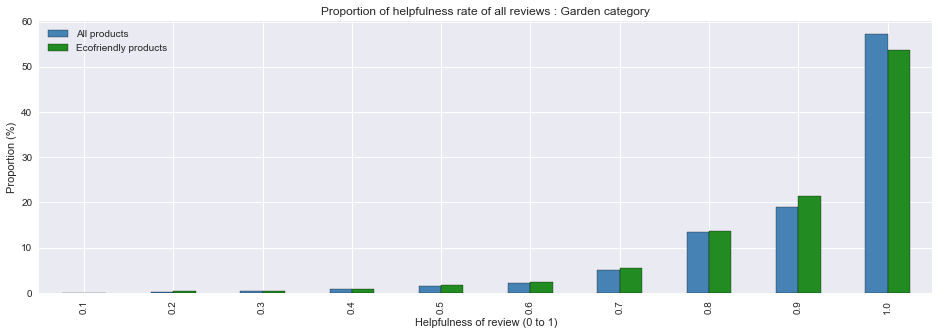

In [240]:
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

gardenall_helpful_pd.plot(kind='bar', color=["steelblue","forestgreen"], edgecolor='black',ax = axes)
axes.set_xlabel("Helpfulness of review (0 to 1)")
axes.set_ylabel("Proportion (%)")
axes.set_title("Proportion of helpfulness rate of all reviews : Garden category")

In [283]:
gardenbio_review_perproduct = np.sum(gardenbio_nbreviews_pd['freq'])/len(gardenbio_nbreviews_pd)
print("Garden category : Mean reviews per ecofriendly product : " + str(gardenbio_review_perproduct))
print("Garden category : Mean helpfulness per review (ecofriendly products) : " + str(gardenbio_mean_helpful))

Garden category : Mean reviews per ecofriendly product : 12.568521031207599
Garden category : Mean helpfulness per review (ecofriendly products) : 0.9060171447411803


In [282]:
gardenall_review_perproduct = np.sum(gardenall_nbreviews_pd['freq'])/len(gardenall_nbreviews_pd)
print("Garden category : Mean reviews per general product : " + str(gardenall_review_perproduct))
print("Garden category : Mean helpfulness per review (all products) : " + str(gardenall_mean_helpful))

Garden category : Mean reviews per general product : 9.373962107487923
Garden category : Mean helpfulness per review (all products) : 0.9118116172700923


<br>

**Books**

In [ ]:
booksbio_nbrev_perproduct=  books_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [ ]:
booksbio_nbreviews_DF = spark.createDataFrame(booksbio_nbrev_perproduct, ['productID','freq'])

In [ ]:
booksbio_nbreviews_Pandas = booksbio_nbreviews_DF.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
booksbio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

**Home and Kitchen**

Compute histogram of reviews

In [324]:
# Histogram of reviews for ecofriendly products
homebio_nbrev_perproduct = home_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

homebio_nbreviews_DF = spark.createDataFrame(homebio_nbrev_perproduct, ['productID','freq'])
homebio_nbreviews_Pandas = homebio_nbreviews_DF.toPandas()

In [325]:
# Histogram of reviews for all products
homeall_nbrev_perproduct=  home_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

homeall_nbreviews_DF = spark.createDataFrame(homeall_nbrev_perproduct, ['productID','freq'])
homeall_nbreviews_pd = homeall_nbreviews_DF.toPandas()

Compute proportion of helpfulness per comment

In [328]:
# Proportion helpfulness for ecofriendly products
homebio_helpful =  home_review_product_join.rdd.filter(lambda r: (r[7][0]>3))\
            .map(lambda r: [compute_helpful(r[7][0],r[7][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

homebio_helpful_df = spark.createDataFrame(homebio_helpful)
homebio_helpful_pd = homebio_helpful_df.toPandas()
homebio_helpful_pd.columns = ['helpful','freq']
homebio_helpful_pd = homebio_helpful_pd.sort_values('helpful')

homebio_helpful_pd['freq'], homebio_mean_helpful = compute_helpful_proportion(homebio_helpful_pd)
homebio_helpful_pd = homebio_helpful_pd.set_index('helpful')

In [329]:
# Proportion helpfulness for all products
homeall_helpful =  home_reviews.rdd.filter(lambda r: (r[1][0]>3))\
            .map(lambda r: [compute_helpful(r[1][0],r[1][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

homeall_helpful_df = spark.createDataFrame(homeall_helpful)
homeall_helpful_pd = homeall_helpful_df.toPandas()
homeall_helpful_pd.columns = ['helpful','freq']
homeall_helpful_pd = homeall_helpful_pd.sort_values('helpful')

homeall_helpful_pd['freq'], homeall_mean_helpful = compute_helpful_proportion(homeall_helpful_pd)
homeall_helpful_pd = homeall_helpful_pd.set_index('helpful')

In [330]:
# Merge ecofriendly and all products for helpfulness of reviews
homeall_helpful_pd['All products'] = homeall_helpful_pd['freq']
homeall_helpful_pd['Ecofriendly products'] = homebio_helpful_pd['freq']
homeall_helpful_pd = homeall_helpful_pd.drop('freq',axis=1)

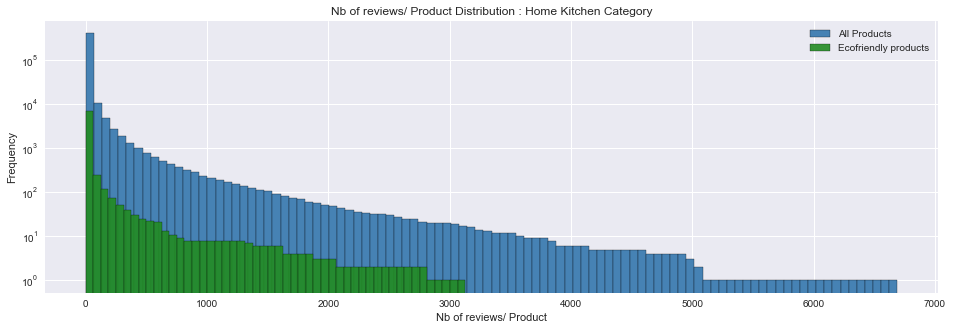

In [327]:
# Plot histogram of reviews
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

ax = homeall_nbreviews_pd.hist(log=True, bins = 100, color="steelblue",edgecolor='black', cumulative=-1, ax=axes)

homebio_nbreviews_Pandas.hist(log=True, bins = 50, color="forestgreen",edgecolor='black',alpha=0.9, cumulative=-1, ax=ax)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution : Home Kitchen Category")

plt.legend(['All Products','Ecofriendly products'])

Text(0.5,1,'Proportion of helpfulness rate of all reviews : Home Kitchen category')

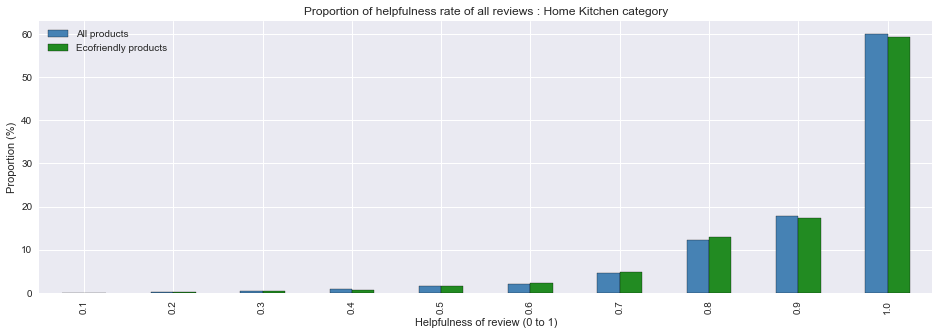

In [331]:
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

homeall_helpful_pd.plot(kind='bar', color=["steelblue","forestgreen"], edgecolor='black',ax = axes)
axes.set_xlabel("Helpfulness of review (0 to 1)")
axes.set_ylabel("Proportion (%)")
axes.set_title("Proportion of helpfulness rate of all reviews : Home Kitchen category")

In [332]:
homebio_review_perproduct = np.sum(homebio_nbreviews_Pandas['freq'])/len(homebio_nbreviews_Pandas)
print("Garden category : Mean reviews per ecofriendly product : " + str(homebio_review_perproduct))
print("Garden category : Mean helpfulness per review (ecofriendly products) : " + str(homebio_mean_helpful))

Garden category : Mean reviews per ecofriendly product : 13.71200464508637
Garden category : Mean helpfulness per review (ecofriendly products) : 0.9146172117668555


In [333]:
homeall_review_perproduct = np.sum(homeall_nbreviews_pd['freq'])/len(homeall_nbreviews_pd)
print("Garden category : Mean reviews per general product : " + str(homeall_review_perproduct))
print("Garden category : Mean helpfulness per review (all products) : " + str(homeall_mean_helpful))

Garden category : Mean reviews per general product : 10.369283570956725
Garden category : Mean helpfulness per review (all products) : 0.9167956786696689


Average Review per product 

In [359]:
data_review_product = [ [grocerybio_review_perproduct,groceryall_review_perproduct],\
                       [healthcarebio_review_perproduct,healthcareall_review_perproduct],\
                       [gardenbio_review_perproduct,gardenall_review_perproduct],\
                       [homebio_review_perproduct,homeall_review_perproduct] ]
mean_review_product = pd.DataFrame(data_review_product, 
                                  index = ['grocery','healthcare','garden','home'], columns=['Ecofriendly Products','All Products'])

Text(0.5,1,'Average number of reviews per product')

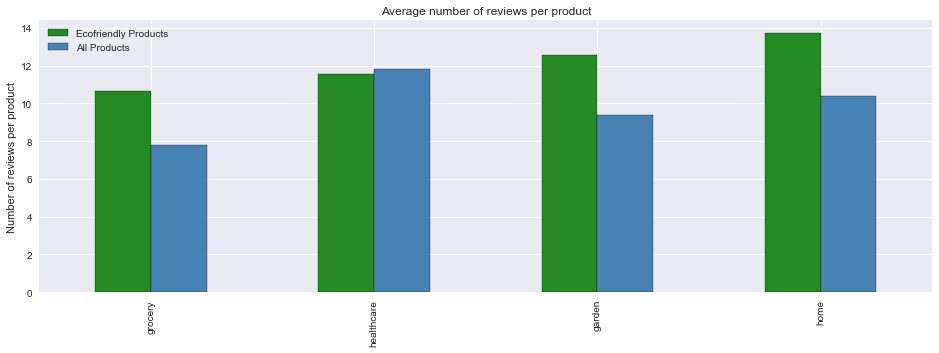

In [360]:
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

mean_review_product.plot(kind='bar', color=['forestgreen','steelblue'], edgecolor='black', ax=axes)
axes.set_ylabel("Number of reviews per product")
axes.set_title("Average number of reviews per product")

As we can see, eco-friendly products tend to have more reviews than non-eco friendly product. Our assumptions to explains this is that people often buy eco-friendly products mainly because it is an eco products. Thus they might more willing to leave a comment saying whether or not the product satisfied their wishes. 

This behavior can also be extended to every products. But in general, people leave more reviewes because of a non satisfaction with a product than a satisfaction. Futhermore they are very strict with a non eco-friendly product that can described as an eco-friendly product.

Mean helpfulness per review

In [362]:
data_review_product = [ [grocerybio_mean_helpful,groceryall_mean_helpful],\
                       [healthcarebio_mean_helpful,healthcareall_mean_helpful],\
                       [gardenbio_mean_helpful,gardenall_mean_helpful],\
                       [homebio_mean_helpful,homeall_mean_helpful] ]
mean_helpfulness_review = pd.DataFrame(data_review_product, 
                                  index = ['grocery','healthcare','garden','home'], columns=['Ecofriendly Products','All Products'])

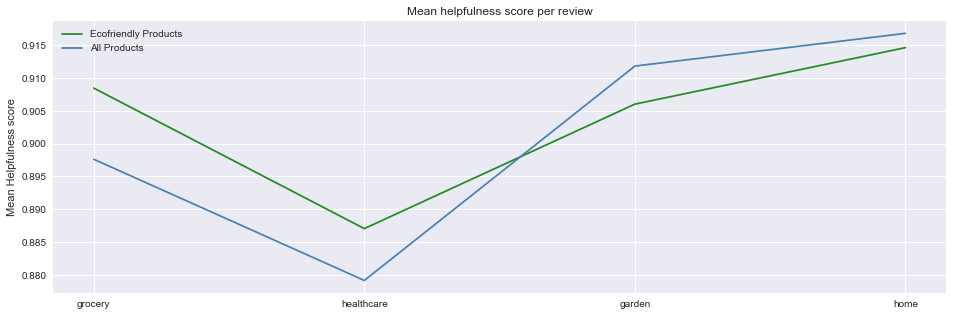

In [370]:
fig, axes = plt.subplots(); fig.set_size_inches(16,5)

axes.plot(mean_helpfulness_review.index,mean_helpfulness_review['Ecofriendly Products'], label="Ecofriendly Products", color='forestgreen')
axes.plot(mean_helpfulness_review.index,mean_helpfulness_review['All Products'], label="All Products", color='steelblue')


#mean_helpfulness_review.plot(color=['forestgreen','steelblue'], ax=axes)
axes.set_ylabel("Mean Helpfulness score")
axes.set_title("Mean helpfulness score per review")
plt.legend(['Ecofriendly Products', 'All Products'])

---
<a id='section4'></a>
##  **4) Price average per year**


Eco-friendly products can be more expensive due to some high cost production (such as bio product for example). So as we did before, we are going to analyse what we can extract from that. 

As we did in the second section, we compute for each item its released year in a new dataframe. Then when the price of the item if definine, we add it to the dataframe for each item’s id.
And finally we count the mean of the prices for every year. Sometimes it can happend that some years do not have prices (either the price was set to null or there were no items). So we ad dit by a 0 price. 
As we said, eco-product is not a very old concept in our society and might not be present at the beginning of the sales or described as eco-product. 

What we expect : by the time goes, the importance and price of product over the time.


**1) Grocery Food**

In [49]:
grocery_products_bio_df = spark.createDataFrame(grocery_filter_products_bio)

grocery_year_join = grocery_products_bio_df.join(grocerybio_firstrev, ['asin'])
grocery_year_join_pd = grocery_year_join.toPandas()

grocery_year_join_pd['Year'] = pd.to_datetime(grocery_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
grocery_year_join_pd = grocery_year_join_pd[np.isfinite(grocery_year_join_pd['price'])]

grocery_year_join_pd = grocery_year_join_pd[['price', 'Year']]

grocery_year_join_pd_mean = grocery_year_join_pd.groupby(['Year']).mean()
grocery_year_join_nb_products,_ = np.histogram(grocery_year_join_pd['Year'], bins=len(grocery_year_join_pd_mean))
grocery_year_join_pd_mean.columns = ['price : Bio products']

grocery_year_join_pd_error = grocery_year_join_pd.groupby(['Year']).std()
for i in range(len(grocery_year_join_pd_mean)):
    grocery_year_join_pd_error.iloc[i] = grocery_year_join_pd_error.iloc[i]/grocery_year_join_nb_products[i]


In [50]:
grocery_year_join_pd_mean.loc[2000] = 0
grocery_year_join_pd_mean.loc[2002] = 0
grocery_year_join_pd_mean.loc[2003] = 0
grocery_year_join_pd_mean = grocery_year_join_pd_mean.sort_index()

In [51]:
# Mean of price per year of all products from Patio lawn and Garden
grocery_all_year_join = grocery_food_datacleaned.join(groceryall_firstrev, ['asin'])
grocery_all_year_join_pd = grocery_all_year_join.toPandas()

grocery_all_year_join_pd['Year'] = pd.to_datetime(grocery_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

grocery_all_year_join_pd = grocery_all_year_join_pd[np.isfinite(grocery_all_year_join_pd['price'])]
grocery_all_year_join_pd = grocery_all_year_join_pd[['price', 'Year']]

grocery_all_year_join_pd = grocery_all_year_join_pd.groupby(['Year']).mean()

grocery_all_year_join_pd.columns =['price : all products']

Text(0.5,1,'Grocery : Mean price of products per year $')

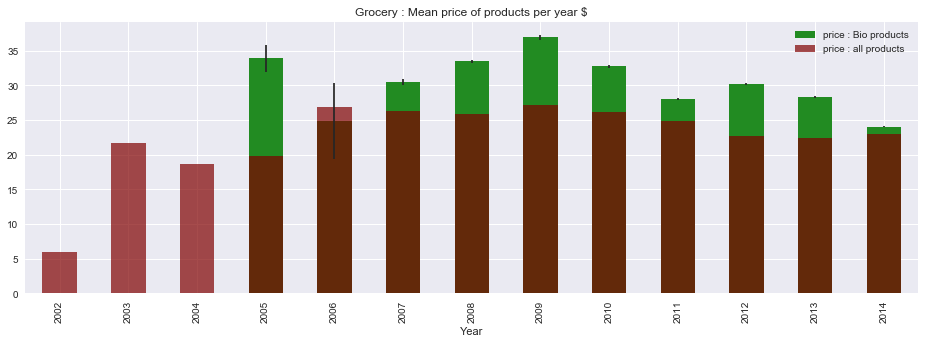

In [52]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = grocery_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=grocery_year_join_pd_error['price'])
grocery_all_year_join_pd.plot(kind='bar', alpha=0.7, color='maroon', ax =ax)
plt.title('Grocery : Mean price of products per year $')

**2) Healthcare**

In [53]:
healthcare_products_bio_df = spark.createDataFrame(healthcare_filter_products_bio)

healthcarebio_year_join = healthcare_products_bio_df.join(healthcarebio_firstrev, ['asin'])
healthcarebio_year_join_pd = healthcarebio_year_join.toPandas()

healthcarebio_year_join_pd['Year'] = pd.to_datetime(healthcarebio_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcarebio_year_join_pd = healthcarebio_year_join_pd[np.isfinite(healthcarebio_year_join_pd['price'])]

healthcarebio_year_join_pd = healthcarebio_year_join_pd[['price', 'Year']]

healthcarebio_year_join_pd_mean = healthcarebio_year_join_pd.groupby(['Year']).mean()
healthcarebio_year_join_nb_products,_ = np.histogram(healthcarebio_year_join_pd['Year'], bins=len(healthcarebio_year_join_pd_mean))

healthcarebio_year_join_pd_mean.columns = ['price : Bio products']


healthcarebio_year_join_pd_error = healthcarebio_year_join_pd.groupby(['Year']).std()
for i in range(len(healthcarebio_year_join_pd_mean)):
    healthcarebio_year_join_pd_error.iloc[i] = healthcarebio_year_join_pd_error.iloc[i]/healthcarebio_year_join_nb_products[i]


In [54]:
healthcarebio_year_join_pd_mean.loc[1998] = 0
healthcarebio_year_join_pd_mean.loc[1999] = 0
healthcarebio_year_join_pd_mean.loc[2000] = 0
healthcarebio_year_join_pd_mean.loc[2001] = 0
healthcarebio_year_join_pd_mean.loc[2002] = 0
healthcarebio_year_join_pd_mean = healthcarebio_year_join_pd_mean.sort_index()

In [55]:
# Mean of price per year of all products from Patio lawn and Garden
healthcare_all_year_join = healthcare_datacleaned.join(healthcareall_firstrev, ['asin'])
healthcare_all_year_join_pd = healthcare_all_year_join.toPandas()

healthcare_all_year_join_pd['Year'] = pd.to_datetime(healthcare_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

healthcare_all_year_join_pd = healthcare_all_year_join_pd[np.isfinite(healthcare_all_year_join_pd['price'])]
healthcare_all_year_join_pd = healthcare_all_year_join_pd[['price', 'Year']]

healthcare_all_year_join_pd = healthcare_all_year_join_pd.groupby(['Year']).mean()

healthcare_all_year_join_pd.columns =['price : all products']

Text(0.5,1,'Healthcare : Mean price of products per year $')

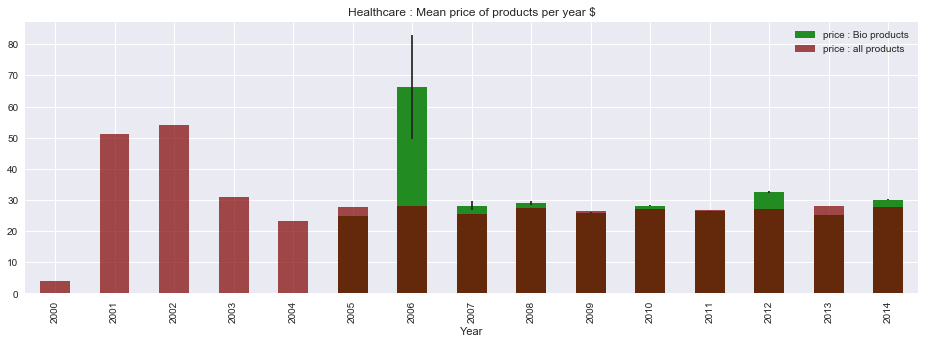

In [56]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = healthcarebio_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=healthcarebio_year_join_pd_error['price'])
healthcare_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='maroon')
plt.title('Healthcare : Mean price of products per year $')

**3) Patio Lawn Garden**

In [57]:
DF_filter_products_bio = spark.createDataFrame(patiolawn_garden_filter_products_bio)

garden_year_join = DF_filter_products_bio.join(gardenbio_firstrev, ['asin'])
garden_year_join_pd = garden_year_join.toPandas()

garden_year_join_pd['Year'] = pd.to_datetime(garden_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
garden_year_join_pd = garden_year_join_pd[np.isfinite(garden_year_join_pd['price'])]

garden_year_join_pd = garden_year_join_pd[['price', 'Year']]

garden_year_join_pd_mean = garden_year_join_pd.groupby(['Year']).mean()
garden_year_join_pd_nb_products,_ = np.histogram(garden_year_join_pd['Year'], bins=len(garden_year_join_pd_mean))

garden_year_join_pd_mean.columns = ['price : Bio products']

garden_year_join_pd_error = garden_year_join_pd.groupby(['Year']).std()
for i in range(len(garden_year_join_pd_error)):
    garden_year_join_pd_error.iloc[i] = garden_year_join_pd_error.iloc[i]/garden_year_join_pd_nb_products[i]


In [58]:
# Mean of price per year of all products from Patio lawn and Garden
garden_all_year_join = patiolawn_garden_datacleaned.join(gardeneall_firstrev, ['asin'])
garden_all_year_join_pd = garden_all_year_join.toPandas()

garden_all_year_join_pd['Year'] = pd.to_datetime(garden_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

garden_all_year_join_pd = garden_all_year_join_pd[np.isfinite(garden_all_year_join_pd['price'])]
garden_all_year_join_pd = garden_all_year_join_pd[['price', 'Year']]

garden_all_year_join_pd = garden_all_year_join_pd.groupby(['Year']).mean()

garden_all_year_join_pd.columns =['price : all products']

In [59]:
garden_year_join_pd_mean.loc[1998] = 0
garden_year_join_pd_mean.loc[1999] = 0
garden_year_join_pd_mean = garden_year_join_pd_mean.sort_index()

Text(0.5,1,'Patio Lawn - Garden : Mean price of products per year $')

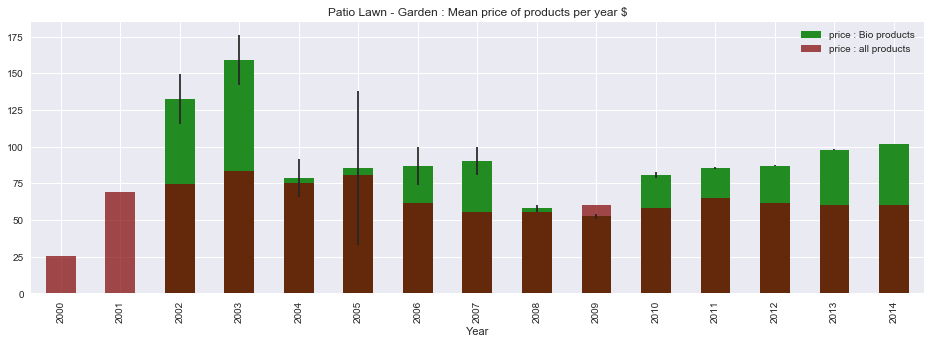

In [60]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = garden_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=garden_year_join_pd_error['price'])
garden_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='maroon')
plt.title('Patio Lawn - Garden : Mean price of products per year $')

**4) Home and Kitchen**

In [61]:
home_filter_products_bio = spark.createDataFrame(home_filter_eco)

home_year_join = home_filter_products_bio.join(homeall_firstrev, ['asin'])
home_year_join_pd = home_year_join.toPandas()

home_year_join_pd['Year'] = pd.to_datetime(home_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
home_year_join_pd = home_year_join_pd[np.isfinite(home_year_join_pd['price'])]

home_year_join_pd = home_year_join_pd[['price', 'Year']]

home_year_join_pd_mean = home_year_join_pd.groupby(['Year']).mean()
home_year_join_pd_nb_products,_ = np.histogram(home_year_join_pd['Year'], bins=len(home_year_join_pd_mean))

home_year_join_pd_mean.columns = ['price : Bio products']

home_year_join_pd_error = home_year_join_pd.groupby(['Year']).std()
for i in range(len(home_year_join_pd_error)):
    home_year_join_pd_error.iloc[i] = home_year_join_pd_error.iloc[i]/home_year_join_pd_nb_products[i]


In [62]:
# Mean of price per year of all products from Patio lawn and Garden
home_all_year_join = home_datacleaned.join(homeall_firstrev, ['asin'])
home_all_year_join_pd = home_all_year_join.toPandas()

home_all_year_join_pd['Year'] = pd.to_datetime(home_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

home_all_year_join_pd = home_all_year_join_pd[np.isfinite(home_all_year_join_pd['price'])]
home_all_year_join_pd = home_all_year_join_pd[['price', 'Year']]

home_all_year_join_pd = home_all_year_join_pd.groupby(['Year']).mean()

home_all_year_join_pd.columns =['price : all products']

In [63]:
home_year_join_pd_mean.loc[2000] = 0
home_year_join_pd_mean = home_year_join_pd_mean.sort_index()

Text(0.5,1,'Home and Kitchen : Mean price of products per year $')

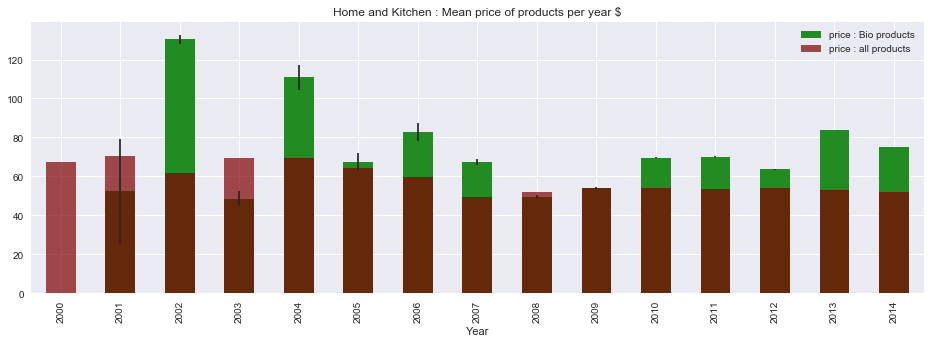

In [64]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = home_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=home_year_join_pd_error['price'])
home_all_year_join_pd.plot(kind='bar' , ax = ax,alpha=0.7, color='maroon')
plt.title('Home and Kitchen : Mean price of products per year $')

We can see in those graphs above that the eco-friendly products are in average more expensive than the global products for each category. However we can not observe a growing trend in the price for these products. 

This field came in the market a bit late. From 2002 for Home and Kitchen and Patio lawn Garden or  2006 with Healthcare where we can see a release of eco products with high prices with high variance.  We can not rely on it but it gives a global overview. We can see that the first years the ecofriendly products were really expensive.

__Global Price Information per Category__

In [65]:
def price_difference_percentage(ecofriendly_series, all_series):
    difference = ecofriendly_series.divide(all_series)*100
    difference = difference.iloc[difference.nonzero()]
    difference = difference.mean()-100
    
    return difference

In [66]:
def price_difference_dollars(ecofriendly_series, all_series):
    difference = ecofriendly_series.sub(all_series)
    difference = difference.iloc[ecofriendly_series.nonzero()]
    difference = difference.mean()
    
    return difference

In [67]:
home_difference_perc = price_difference_percentage(home_year_join_pd_mean['price : Bio products'], \
                                                   home_all_year_join_pd['price : all products'])

grocery_difference_perc = price_difference_percentage(grocery_year_join_pd_mean['price : Bio products'], \
                                                      grocery_all_year_join_pd['price : all products'])

healthcare_difference_perc = price_difference_percentage(healthcarebio_year_join_pd_mean['price : Bio products'], \
                                                         healthcare_all_year_join_pd['price : all products'])

garden_difference_perc = price_difference_percentage(garden_year_join_pd_mean['price : Bio products'], \
                                                     garden_all_year_join_pd['price : all products'])


difference_perc_df = pd.DataFrame([home_difference_perc,grocery_difference_perc,healthcare_difference_perc,garden_difference_perc], \
                                  index=['home','grocery','healthcare','garden'], columns=["Difference Percentage %"])


In [68]:
home_difference_dollars = price_difference_dollars(home_year_join_pd_mean['price : Bio products'], \
                                                   home_all_year_join_pd['price : all products'])

grocery_difference_dollars = price_difference_dollars(grocery_year_join_pd_mean['price : Bio products'], \
                                                      grocery_all_year_join_pd['price : all products'])

healthcare_difference_dollars = price_difference_dollars(healthcarebio_year_join_pd_mean['price : Bio products'], \
                                                         healthcare_all_year_join_pd['price : all products'])

garden_difference_dollars = price_difference_dollars(garden_year_join_pd_mean['price : Bio products'], \
                                                     garden_all_year_join_pd['price : all products'])

difference_dollars_df = pd.DataFrame([home_difference_dollars,grocery_difference_dollars,healthcare_difference_dollars,garden_difference_dollars], \
                                     index=['home','grocery','healthcare','garden'], columns=["Diffrence Dollars $"])

In [69]:
homebio_mean_dollars = home_year_join_pd_mean['price : Bio products'].iloc[1:-1].mean()
homeall_mean_dollars = home_all_year_join_pd['price : all products'].iloc[1:-1].mean()

grocerybio_mean_dollars = grocery_year_join_pd_mean['price : Bio products'].iloc[3:-1].mean()
groceryall_mean_dollars = grocery_all_year_join_pd['price : all products'].iloc[3:-1].mean()

healthcarebio_mean_dollars = healthcarebio_year_join_pd_mean['price : Bio products'].iloc[5:-1].mean()
healthcareall_mean_dollars = healthcare_all_year_join_pd['price : all products'].iloc[5:-1].mean()

gardenbio_mean_dollars = garden_year_join_pd_mean['price : Bio products'].iloc[2:-1].mean()
gardenall_mean_dollars = garden_all_year_join_pd['price : all products'].iloc[2:-1].mean()

mean_price_df = pd.DataFrame([[homebio_mean_dollars,homeall_mean_dollars],\
                             [grocerybio_mean_dollars,groceryall_mean_dollars],\
                             [healthcarebio_mean_dollars,healthcareall_mean_dollars],\
                             [gardenbio_mean_dollars,gardenall_mean_dollars]],\
                             index=['home','grocery','healthcare','garden'], columns=["Ecofriendly Mean_Price","All Mean_Price"])


Text(0.5,1,'Average Price ($) per Category')

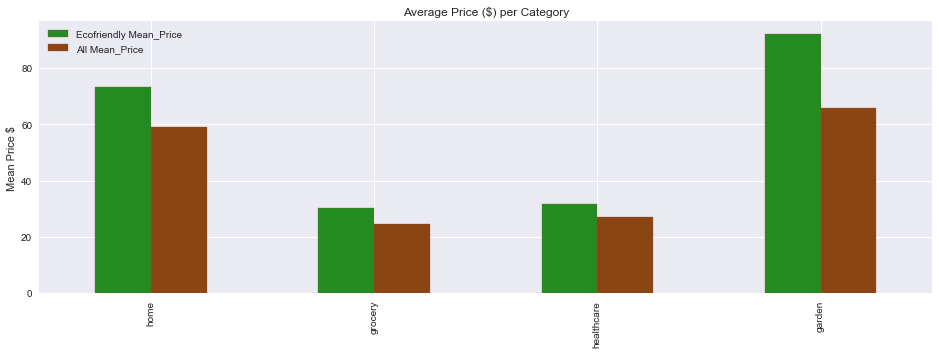

In [70]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

mycolor = ['forestgreen','saddlebrown']
mean_price_df.plot(kind='bar', ax=axes, color=mycolor,edgecolor='sienna')
plt.ylabel("Mean Price $")
plt.title("Average Price ($) per Category")

Eco friendly products tend to be more expensive than non-eco ones. This result illustrates more what is the tendancy that eco products are more costly. We can not compare prices between categories because it makes no sense, they do not have the same application (ie grocery vs home items makes no sens)

Text(0.5,1,'Mean Price Difference ($) between Ecofriendly products VS All products')

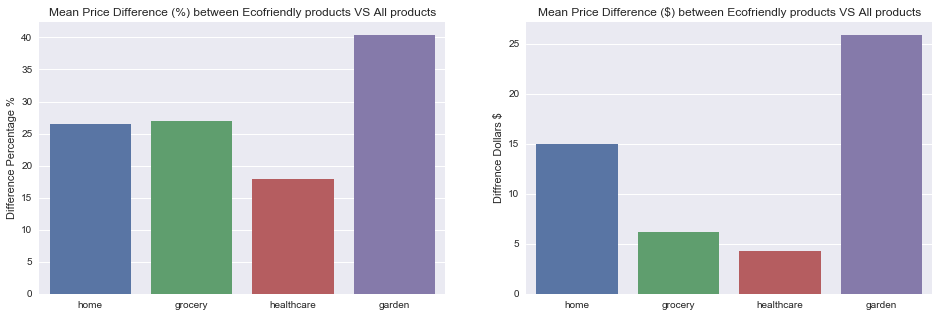

In [71]:
fig, axes = plt.subplots(1,2); fig.set_size_inches(16,5)


ax1 = sns.barplot(x=difference_perc_df.index,y=difference_perc_df['Difference Percentage %'], ax=axes[0])
ax1.set_title("Mean Price Difference (%) between Ecofriendly products VS All products")
ax2 = sns.barplot(x=difference_dollars_df.index,y=difference_dollars_df['Diffrence Dollars $'], ax=axes[1])
ax2.set_title("Mean Price Difference ($) between Ecofriendly products VS All products")

---
<a id='section5'></a>
## **5)** Overall rating per Category


**1) Grocery Food**

In [72]:
grocerybio_overall =  grocery_food_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [73]:
grocerybio_overall_DF = spark.createDataFrame(grocerybio_overall)

grocerybio_overall_pd = grocerybio_overall_DF.toPandas()
grocerybio_overall_pd.columns= ['overall','occurences']
grocerybio_overall_pd = grocerybio_overall_pd.set_index('overall')

grocerybio_sum_ratings = grocerybio_overall_pd['occurences'].sum()
grocerybio_percentage = grocerybio_overall_pd['occurences'].divide(grocerybio_sum_ratings)

In [74]:
groceryall_overall =  grocery_food_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [75]:
groceryall_overall_df = spark.createDataFrame(groceryall_overall)

groceryall_overall_pd = groceryall_overall_df.toPandas()
groceryall_overall_pd.columns= ['overall','occurences']
groceryall_overall_pd = groceryall_overall_pd.set_index('overall')

groceryall_sum_ratings = groceryall_overall_pd['occurences'].sum()
groceryall_percentage = groceryall_overall_pd['occurences'].divide(groceryall_sum_ratings)

In [76]:
grocery_rating_proportion = pd.DataFrame()
grocery_rating_proportion['All Products Proportion'] = groceryall_percentage*100
grocery_rating_proportion['Ecofriendly Products Proportion'] = grocerybio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

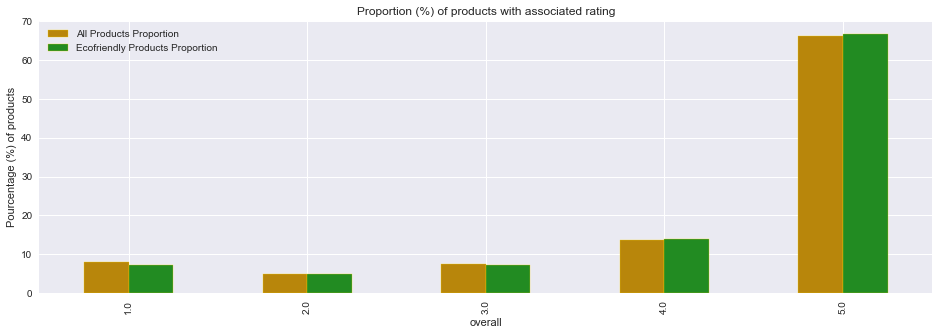

In [77]:
fig, axes = plt.subplots(1,1); 
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

grocery_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

**2) Healthcare**

In [78]:
healthcarebio_overall =  healthcare_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [79]:
healthcarebio_overall_DF = spark.createDataFrame(healthcarebio_overall)

healthcarebio_overall_pd = healthcarebio_overall_DF.toPandas()
healthcarebio_overall_pd.columns= ['overall','occurences']
healthcarebio_overall_pd = healthcarebio_overall_pd.set_index('overall')

healthcarebio_sum_ratings = healthcarebio_overall_pd['occurences'].sum()
healthcarebio_percentage = healthcarebio_overall_pd['occurences'].divide(healthcarebio_sum_ratings)

In [80]:
healthcareall_overall =  healthcare_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [81]:
healthcareall_overall_df = spark.createDataFrame(healthcareall_overall)

healthcareall_overall_pd = healthcareall_overall_df.toPandas()
healthcareall_overall_pd.columns= ['overall','occurences']
healthcareall_overall_pd = healthcareall_overall_pd.set_index('overall')

healthcareall_sum_ratings = healthcareall_overall_pd['occurences'].sum()
healthcareall_percentage = healthcareall_overall_pd['occurences'].divide(healthcareall_sum_ratings)

In [82]:
healthcare_rating_proportion = pd.DataFrame()
healthcare_rating_proportion['All Products Proportion'] = healthcareall_percentage*100
healthcare_rating_proportion['Ecofriendly Products Proportion'] = healthcarebio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

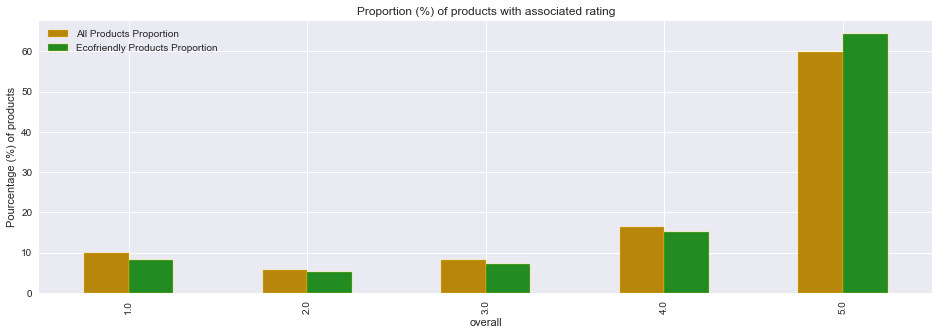

In [83]:
fig, axes = plt.subplots(1,1); 
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

healthcare_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

**3) Patio Garden**

In [84]:
gardenbio_overall =  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [85]:
gardenbio_overall_DF = spark.createDataFrame(gardenbio_overall)

gardenbio_overall_pd = gardenbio_overall_DF.toPandas()
gardenbio_overall_pd.columns= ['overall','occurences']
gardenbio_overall_pd = gardenbio_overall_pd.set_index('overall')

gardenbio_sum_ratings = gardenbio_overall_pd['occurences'].sum()
gardenbio_percentage = gardenbio_overall_pd['occurences'].divide(gardenbio_sum_ratings)

In [86]:
gardenall_overall =  patiolawn_garden_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [87]:
gardenall_overall_df = spark.createDataFrame(gardenall_overall)

gardenall_overall_pd = gardenall_overall_df.toPandas()
gardenall_overall_pd.columns= ['overall','occurences']
gardenall_overall_pd = gardenall_overall_pd.set_index('overall')

gardenall_sum_ratings = gardenall_overall_pd['occurences'].sum()
gardenall_percentage = gardenall_overall_pd['occurences'].divide(gardenall_sum_ratings)

In [88]:
garden_rating_proportion = pd.DataFrame()
garden_rating_proportion['All Products Proportion'] = gardenall_percentage*100
garden_rating_proportion['Ecofriendly Products Proportion'] = gardenbio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

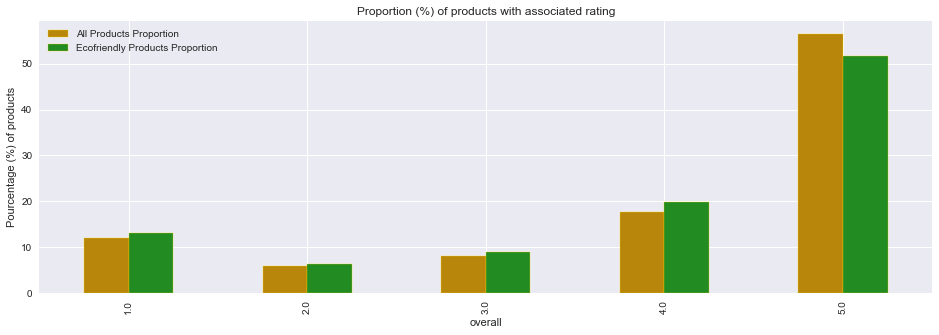

In [89]:
fig, axes = plt.subplots(1,1); 
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

garden_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

**4) Home Kitchen**

In [90]:
homebio_overall =  home_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [91]:
homebio_overall_DF = spark.createDataFrame(homebio_overall)

homebio_overall_pd = homebio_overall_DF.toPandas()
homebio_overall_pd.columns= ['overall','occurences']
homebio_overall_pd = homebio_overall_pd.set_index('overall')

homebio_sum_ratings = homebio_overall_pd['occurences'].sum()
homebio_percentage = homebio_overall_pd['occurences'].divide(homebio_sum_ratings)

In [92]:
homeall_overall =  home_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [93]:
homeall_overall_df = spark.createDataFrame(homeall_overall)

homeall_overall_pd = homeall_overall_df.toPandas()
homeall_overall_pd.columns= ['overall','occurences']
homeall_overall_pd = homeall_overall_pd.set_index('overall')

homeall_sum_ratings = homeall_overall_pd['occurences'].sum()
homeall_percentage = homeall_overall_pd['occurences'].divide(homeall_sum_ratings)

In [94]:
home_rating_proportion = pd.DataFrame()
home_rating_proportion['All Products Proportion'] = homeall_percentage*100
home_rating_proportion['Ecofriendly Products Proportion'] = homebio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

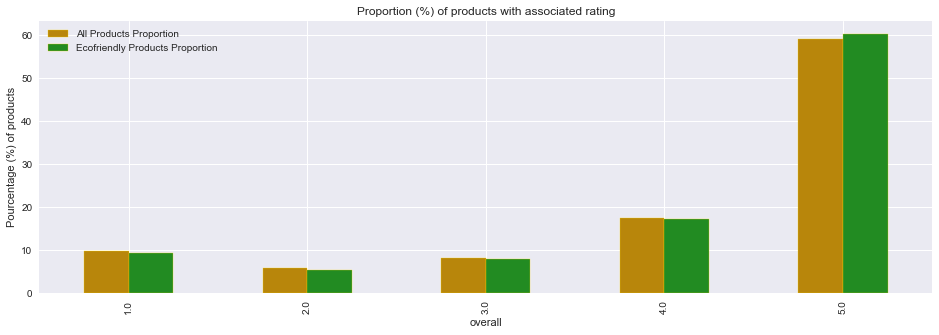

In [95]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

home_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

__Global Overall Rating Comparison__

In [96]:
grocerybio_mean_rating = grocery_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
groceryall_mean_rating = grocery_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100

healthcarebio_mean_rating= healthcare_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
healthcareall_mean_rating = healthcare_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100

gardenbio_mean_rating = garden_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
gardenall_mean_rating = garden_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100

homebio_mean_rating = home_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
homeall_mean_rating = home_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100


In [97]:
mean_rating = pd.DataFrame(index=['grocery','healthcare','garden','home'])
mean_rating['Mean Bio Rating'] = [grocerybio_mean_rating,healthcarebio_mean_rating,gardenbio_mean_rating,homebio_mean_rating]
mean_rating['Mean All Rating'] = [groceryall_mean_rating,healthcareall_mean_rating,gardenall_mean_rating,homeall_mean_rating]

Text(0,0.5,'Overall rating')

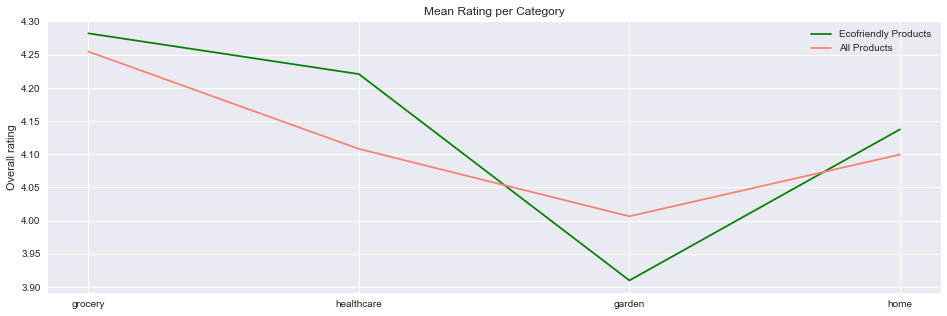

In [98]:
fig, axes = plt.subplots()
fig.set_size_inches(16,5)

axes.plot(mean_rating.index,mean_rating['Mean Bio Rating'], label="Ecofriendly Products", color='green')
axes.plot(mean_rating.index,mean_rating['Mean All Rating'], label="All Products", color='salmon')

plt.title("Mean Rating per Category")
plt.legend(['Ecofriendly Products', 'All Products'])
plt.ylabel("Overall rating")

---
<a id='section6'></a>
## **6)** Correlation SalesRank and Rating Analysis


We now want to analyze the correlations with the salerank.
Indeed, is the salerank position related to the number of reviews or the overall rating of the products ?
We will even add the publication year of each product.

In [410]:
# Average rating for each products
# First, add every overall rating for each product (we will divide by the number of reviews after)
gardenall_product_rating =  patiolawn_garden_reviews.rdd.map(lambda r: [r[0],r[2]]) \
            .reduceByKey(lambda a,b: a+b)

gardenall_product_rating_df = spark.createDataFrame(gardenall_product_rating)

gardenall_product_rating_pd = gardenall_product_rating_df.toPandas()
gardenall_product_rating_pd.columns= ['productID','rating']

# Join average rating per product with number of reviews per product
# the index is productID
gardenall_info_products = gardenall_nbreviews_pd.set_index('productID').join(gardenall_product_rating_pd.set_index('productID'))


gardenall_info_products.columns = ['nb_reviews','rating']
# Divide the rating by the number of overall ratings per product
gardenall_info_products['rating'] = gardenall_info_products['rating'].divide(gardenall_info_products['nb_reviews'])


In [411]:
# Extract the salesRank per product
gardenall_salesrank = patiolawn_garden_datacleaned.rdd.flatMap(lambda r: [(r[0], r[5])])

schema = StructType([
    StructField("productID", StringType(), True),
    StructField("salesRank", IntegerType(), True)
])

gardenall_salesrank_df = spark.createDataFrame(gardenall_salesrank, schema=schema)
gardenall_salesrank_pd = gardenall_salesrank_df.toPandas()

# Join the previous dataframe (rating + nb_reviews) with salesRank
gardenall_info_products = gardenall_info_products.join(gardenall_salesrank_pd.set_index('productID'))
gardenall_info_products = gardenall_info_products.dropna()

# We will now add the Publication Year per product
gardeneall_firstrev_pd.columns = ['productID','Year']
gardenall_info_products = gardenall_info_products.join(gardeneall_firstrev_pd.set_index('productID'))

In [412]:
gardenall_info_products.sort_values('nb_reviews', ascending=False).head()

,nb_reviews,rating,salesRank,Year
productID,,,,
B000HCLLMM,3180,4.545283,1081.0,2007
B000071NUS,2348,4.266610,41.0,2003
B00004R9VV,2091,4.130560,111.0,2001
B00004SD7B,1707,4.793790,3668.0,2002
B000WEOQV8,1466,4.854707,9.0,2008


We will now try to observe the correlations between the columns. 

In [413]:
gardenall_filtered_info_products = gardenall_info_products[gardenall_info_products['nb_reviews']>100]

In [414]:
gardenall_filtered_info_products.corr()

,nb_reviews,rating,salesRank,Year
nb_reviews,1.000000,0.033764,-0.108203,-0.125247
rating,0.033764,1.000000,-0.090120,0.034341
salesRank,-0.108203,-0.090120,1.000000,-0.224840
Year,-0.125247,0.034341,-0.224840,1.000000


The correlation between the column do not give any valuable information. Indeed it seems there is no correlation between the columns. 
We will explore a bit further by grouping the different products in clusters following the 'Year' and the 'nb_reviews'. Then in these clusters which will have equivalent popularity (and associated year) we will check if the rating is correlated with the salesrank. 

In [415]:
#X = filtered['nb_reviews'].values
X = gardenall_filtered_info_products[['nb_reviews','Year']].values
numb_clusters = 80
kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(X)

correlation_list = []
for i in range(numb_clusters):
    myind = kmeans.labels_ == i
    clustered_info_product = filtered.iloc[myind]
    if(len(clustered_info_product)>1):
        current_correlation = clustered_info_product['rating'].corr(clustered_info_product['salesRank'])
        correlation_list.append(current_correlation)

In [416]:
# Compute the average correlation between rating and salesrank
print("Average correlation (in clusters) between Rating and Salesrank : "+str(np.sum(correlation_list)/len(correlation_list)))

Average correlation (in clusters) between Rating and Salesrank : -0.04410063744041425


It seems that there is no correlation between the rating and the salesrank.
We can observe a cluster to understand why.

In [417]:
# This will show the last cluster computed
print("Correlation between Rating & salesRank for last cluster : "+str(current_correlation))
clustered_info_product

Correlation between Rating & salesRank for last cluster : 0.477247346073349


,nb_reviews,rating,salesRank,Year
productID,,,,
B002DM1Z5C,471,3.934183,588.0,2010
B00005AKZE,473,4.357294,2064.0,2002
B0000DINGG,477,3.784067,224.0,2007
B000NZZG3S,475,4.526316,564.0,2007
B0001WV010,477,4.584906,2728.0,2006
B002ZVOLY8,479,3.757829,1691.0,2010


The pearson correlation coefficient goes from -1 to 1. We could expect the correlation to be -1, if we think that if the rating is really high then the salesRank is really low (top position).

We can observe that the clustering is here well performed where the values in nb_reviews and year are equivalent.
Then, observing the rating feature, we can say that there is no correlation by hand.
Indeed taking the product 'B0000DINGG' with a rating of 3.78 which is low, has the best salesRank position. Whereas the product 'B0001WV010' with a rating of 4.584 which is the best of this cluster, possess the worst salesRank. 

After trying with different clusters numbers, different categories and using products eco-friendly or not, the behavior was remaining the same, there is __no correlation__. That is why we only showed the analysis for one case, avoiding the repetition leading to the same conclusion.

---
<a id='section7'></a>
## **7)** Top Ecofriendly Products Analysis


> Patio Lawn Garden case analysis

__Extraction of top product__

In [449]:
# Average rating for each products
# First, add every overall rating for each product (we will divide by the number of reviews after)
gardenbio_product_rating =  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[0],r[8]]) \
            .reduceByKey(lambda a,b: a+b)

gardenbio_product_rating_df = spark.createDataFrame(gardenbio_product_rating)

gardenbio_product_rating_pd = gardenbio_product_rating_df.toPandas()
gardenbio_product_rating_pd.columns= ['productID','rating']

# Join average rating per product with number of reviews per product
# the index is productID
gardenbio_info_products = gardenbio_nbreviews_pd.set_index('productID').join(gardenbio_product_rating_pd.set_index('productID'))


gardenbio_info_products.columns = ['nb_reviews','rating']
# Divide the rating by the number of overall ratings per product
gardenbio_info_products['rating'] = gardenbio_info_products['rating'].divide(gardenbio_info_products['nb_reviews'])


In [450]:
# Extract the salesRank per product
gardenbio_salesrank = patiolawn_garden_filter_products_bio.flatMap(lambda r: [(r[0], r[5])])

schema = StructType([
    StructField("productID", StringType(), True),
    StructField("salesRank", IntegerType(), True)
])

gardenbio_salesrank_df = spark.createDataFrame(gardenbio_salesrank, schema=schema)
gardenbio_salesrank_pd = gardenbio_salesrank_df.toPandas()

# Join the previous dataframe (rating + nb_reviews) with salesRank
gardenbio_info_products = gardenbio_info_products.join(gardenbio_salesrank_pd.set_index('productID'))
gardenbio_info_products = gardenbio_info_products.dropna()

# We will now add the Publication Year per product
gardenbio_firstrev_pd.columns = ['productID','Year']
gardenbio_info_products = gardenbio_info_products.join(gardenbio_firstrev_pd.set_index('productID'))

In [455]:
gardenbio_info_products.sort_values('salesRank').head()

,nb_reviews,rating,salesRank,Year
productID,,,,
B001AN7RGG,346,4.664740,21.0,2009
B0006OIZO8,166,4.409639,61.0,2009
B0030GEXUO,821,3.856273,96.0,2010
B000FOKXBW,50,4.080000,285.0,2010
B000NZZG3S,475,4.526316,564.0,2007


We observe that the best ecofriendly product for the category 'Patio Lawn Garden' is the 'B001AN7RGG' with a salesRank of 21 and nb_reviews = 346 and the publication year = 2009.


Let's take a look on this product

In [477]:
patiolawn_garden_filter_products_bio.filter(lambda r: (r[0] == "B001AN7RGG")).take(1)

[Row(asin='B001AN7RGG', brand='Weber', category='Patio, Lawn & Garden', description='Get grilling sooner with our odorless, non-toxic fuel cubes that light easily, even when wet. This is the ideal companion for any charcoal grill. Box of 24 cubes. Fast lighting, environmentally safe and smokeless. Can also be used in any well-ventilated indoor or outdoor wood-burning fireplace.', price=7.449999809265137, salesRank=21, title='Weber 7417 FireStarters Lighter Cubes, 24 Count')]

Now we can see that the top ecofriendly product of the Garden category is a pack of environmentally friendly firestarters. Let's observe the other firestarters to draw a comparison.

__Equivalent product comparison__

In [491]:
firestarters = patiolawn_garden_datacleaned.rdd.filter(lambda r: (r[6] != None)) \
    .filter(lambda r: (any(word in r[6].lower() for word in ['firestarters', 'fire starters'])) )

In [497]:
firestarters_df = spark.createDataFrame(firestarters)

firestarters_pd = firestarters_df.toPandas()
firestarters_pd = firestarters_pd.drop(['brand','category'], axis=1)

In [498]:
firestarters_pd

,asin,description,price,salesRank,title
0,B000F62ZAC,Our Fire Starters are made from sawdust and pa...,9.89,2591,Big Green Egg Fire Starters
1,B001AN7RGG,"Get grilling sooner with our odorless, non-tox...",7.45,21,"Weber 7417 FireStarters Lighter Cubes, 24 Count"
2,B00C4ZDYTS,WESTERN Red Hot Fire Starters are made from hi...,22.91,75882,WESTERN 02418 24-Pack Red Hot Fire Starters
3,B00CXPMBAW,Fire & Flavor&#x2019;s story began years ago i...,5.99,6521,Fire &amp; Flavor 24-Piece Fire Starters
4,B00DMXK9P8,Grate Chef 6pk Fire Starters. A Noncombustible...,1.99,134174,Grate Chef 601-1200 6-Pack Fire Starters


We will now observe the description for each product.

In [500]:
firestarters_pd.iloc[0]['description']

'Our Fire Starters are made from sawdust and paraffin and are very effective for quickly and easily lighting lump charcoal without imparting a chemical taste. A box contains 24 cubes. The Electric Starter, if you prefer that method of lighting, will light the charcoal in about eight minutes.\n\nDirections:\n\n~Fill the fire box with lump charcoal to at least 1 inch above the air holes.\n~With the lid open, slide the draft door completely open.\n~Nestle 1 or 2 Big Green Egg Starters into the charcoal and light. After approximately 10 mins, or whenever several coals are burning, close the lid.\n~When the temperature gauge reaches the desired cooking temperature, reduce the airflow by adjusting the dual function metal top and draft door.\n\n** Do not hold Fire Starter in hand to light.'

>Product 0 : Not ecofriendly

In [503]:
firestarters_pd.iloc[1]['description']

'Get grilling sooner with our odorless, non-toxic fuel cubes that light easily, even when wet. This is the ideal companion for any charcoal grill. Box of 24 cubes. Fast lighting, environmentally safe and smokeless. Can also be used in any well-ventilated indoor or outdoor wood-burning fireplace.'

>Product 1 : Ecofriendly (our top product)

In [513]:
firestarters_pd.iloc[2]['description']

'WESTERN Red Hot Fire Starters are made from high quality wax and dried hardwood sawdust to create a fast-starting, clean burning, safe way to quickly and easily light your BBQ fire. They are waterproof and environmentally friendly to give you the finest quality possible.'

>Product 2 : Ecofriendly

In [515]:
firestarters_pd.iloc[3]['description']

'Fire & Flavor&#x2019;s story began years ago in a busy kitchen in Reynolds, Georgia. It began with a love of family, friends, and Southern cuisine. Today Fire & Flavor shares all kinds of ways to make food more delicious, more nutritious, and with less work. Sharing food at the table is a time when many memories are created. Laugher, love and happiness make our world a better place, and at Fire & Flavor we are glad to be able to contribute to your family&#x2019;s culinary experience.'

>Product 3 : Not ecofriendly

In [517]:
firestarters_pd.iloc[4]['description']

'Grate Chef 6pk Fire Starters. A Noncombustible Fire Starter that is non toxic and lights any woos or charcoal fire without the use or taste of lighter fluid. Our Fire Starters are waterproof and are also a great product to use when camping.'

>Product 4 : Not ecofriendly

Let's update the dataframe with our findings.

Remark : We could have classified the Ecofriendly/Or Not products using our preselected dataframe but we wanted to analyze the different type of text and description for this specific case.

In [518]:
firestarters_pd['Ecofriendly'] = [False,True,True,False,False]

In [519]:
firestarters_pd

,asin,description,price,salesRank,title,Ecofriendly
0,B000F62ZAC,Our Fire Starters are made from sawdust and pa...,9.89,2591,Big Green Egg Fire Starters,False
1,B001AN7RGG,"Get grilling sooner with our odorless, non-tox...",7.45,21,"Weber 7417 FireStarters Lighter Cubes, 24 Count",True
2,B00C4ZDYTS,WESTERN Red Hot Fire Starters are made from hi...,22.91,75882,WESTERN 02418 24-Pack Red Hot Fire Starters,True
3,B00CXPMBAW,Fire & Flavor&#x2019;s story began years ago i...,5.99,6521,Fire &amp; Flavor 24-Piece Fire Starters,False
4,B00DMXK9P8,Grate Chef 6pk Fire Starters. A Noncombustible...,1.99,134174,Grate Chef 601-1200 6-Pack Fire Starters,False


We can now draw some conclusion after analyzing the different descriptions and the other features.
The salesRank of our top product seems now more obvious. Indeed compared to the others this one is envorionmentally safe and is not too expensive. The last one seems to be a bit polluting and toxic, explaining his really low price.
Then comparing the 2 ecofriendly firestarters, our top product is highly cheaper.

__Comparison with products from equivalent cluster class (K-means)__

We now want to analyze the products with the same popularity, by number of reviews and the publication year. We will use the previously implemented K-means model of the 'Garden' category to see the equivalent products. 

Our top product has the following features :
- Number of reviews = 346
- Year = 2009
- Rating = 4.6647

In [520]:
index_cluster = (kmeans.labels_ == kmeans.predict([[346, 2009]])[0])
clustered_info_product = filtered.iloc[index_cluster]

In [521]:
clustered_info_product

,nb_reviews,rating,salesRank,Year
productID,,,,
B001AN7RGG,346,4.664740,21.0,2009
B000H5SZ1Y,349,4.739255,775.0,2008
B000WEKNYW,353,4.065156,320.0,2008
B002UP0R2O,349,4.570201,433.0,2009
B005QIYL7E,353,4.070822,16.0,2012
B004L3AQ1U,353,4.580737,4187.0,2011
B0000AH849,349,4.501433,2049.0,2005
B003B6KQZE,351,4.056980,440.0,2010
B00004RALU,346,4.627168,658.0,2001


In [483]:
index_same_cluster = clustered_info_product.index

In [523]:
garden_products_from_cluster = patiolawn_garden_datacleaned.rdd.filter(lambda r: (any(word in r[0].upper() for word in index_same_cluster)))

In [527]:
garden_products_from_cluster_df = spark.createDataFrame(garden_products_from_cluster)

garden_products_from_cluster_pd = garden_products_from_cluster_df.toPandas()
garden_products_from_cluster_pd = garden_products_from_cluster_pd.drop(['category','description'], axis=1)

In [528]:
garden_products_from_cluster_pd

,asin,brand,price,salesRank,title
0,B00004RALU,Weber,54.500000,658,Weber 741001 Silver One-Touch 22-1/2-Inch Kett...
1,B0000AH849,Summit Chemical Co.,3.700000,2049,"Summit 110-12 Mosquito Dunks, 6-Pack"
2,B000H5SZ1Y,Gardex,7.590000,775,Gardex Leaf Scoops
3,B003B6KQZE,AR North America,94.989998,440,"AR Blue Clean AR118 1,500 PSI 1.5 GPM Hand Car..."
4,B004L3AQ1U,None,141.750000,4187,Apollo Horticulture GLK600GW19 600 Watt Grow L...
5,B000WEKNYW,Weber,21.240000,320,Weber 7516 Grill Out Handle Light
6,B001AN7RGG,Weber,7.450000,21,"Weber 7417 FireStarters Lighter Cubes, 24 Count"
7,B005QIYL7E,Intex,37.250000,16,Intex 1000-Gallon Filter Pump AC 110 to 120-Volt
8,B002UP0R2O,Hammocks Rada,63.990002,433,Hammocks Rada Handmade Yucatan Hammock Matrimo...


The resulting dataframe showing the products contained in the same cluster as the top product (firestarters from Weber) do not present the same kind of products. It is composed of multiple objects, from some Mosquito Dunks to Filter Pump. However we can observe that the brand from our top product is represented 3 times in this cluster : 'Weber'. The salesRank associated with these products are approximately in the first 10% of the salesrank. The K-means interestingly grouped some products which have undirect similarities (Brand, salesRank) in addition to the number of reviews. 

---
<a id='section8'></a>
## **8)** Top brand by categories


In this section we are going to have a look at the top ranked brand over the eco-friendly products. At first we computed the means of overall for each brand and then sorted them descending order of the mean.

But we notice something. A brand with only one product with a 5 stars overall will have a higher rank than a brand with 70 reviews and a overall mean of 4.9. Actually, amazon's overall all only integer from 1 to 5. So wi will round those overall to keep the same idea. (ie an overall < 4.5 will be round to 4 whereas an overall =>4.5 to 5)

Then we will keep the 10th first brand with best overall

In [106]:
# This function display the bar char for each top brand per categories
def plotBar(strArg):
    fig, axes = plt.subplots(1,2)

    # Horizontal bar chart
    plt.subplot(221)
    fig.set_size_inches(15,10)
    strArg['nb reviews'].plot.barh(grid=True)
    plt.title("Best brand overall over all product")
    plt.ylabel("Brand")
    plt.xlabel('Number of reviews')

    plt.subplot(222)
    strArg[('overall','mean')].plot(kind='bar', grid=True, rot=40)
    plt.ylabel('Overall mean')
    plt.title('Overall of top 10 brand')

**Grocery and Gourmet food**

In [115]:
gourmet = spark.read.parquet("Grocery_and_Gourmet_Food.parquet")
gourmet = gourmet.toPandas()

In [116]:
# Only groupby brand and do not look at id
top_gourmet = gourmet.groupby('brand').agg(['count','mean'])

# Add the number of reviews
top_gourmet['nb reviews'] = top_gourmet[('overall','count')]

# Clean
#top_gourmet = top_gourmet.drop(columns=[('price','count'),('overall','count'),('salesRank','count'),'unixReviewTime'])
top_gourmet = top_gourmet.drop(columns=[('price','count'),('overall','count'),('salesRank','count')])

# Compute the overall mean round
top_gourmet['round reviews'] = top_gourmet[('overall','mean')].round()

# Keep the 10 best brands
topG = top_gourmet.sort_values(by=['round reviews','nb reviews'], ascending=False).head(10)
topG = topG.sort_values(by=['nb reviews'], ascending=True);

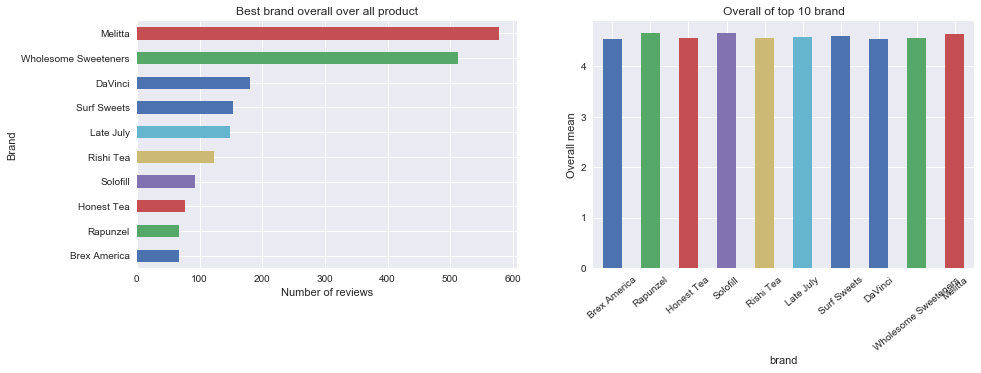

In [119]:
plotBar(topG)

**Healthcare**

In [120]:
health = spark.read.parquet("HealthPersonalCare_joined.parquet")
health = health.toPandas()

In [122]:
# Only groupby brand and do not look at id
top_health = health.groupby('brand').agg(['count','mean'])

# Add the number of reviews
top_health['nb reviews'] = top_health[('overall','count')]

# Clean
#top_health = top_health.drop(columns=[('price','count'),('overall','count'),('salesRank','count'),'unixReviewTime'])
top_health = top_health.drop(columns=[('price','count'),('overall','count'),('salesRank','count')])

# Compute the overall mean round
top_health['round reviews'] = top_health[('overall','mean')].round()

# Keep the 10 best brands
topH = top_health.sort_values(by=['round reviews','nb reviews'], ascending=False).head(10)
topH = topH.sort_values(by=['nb reviews'], ascending=True);

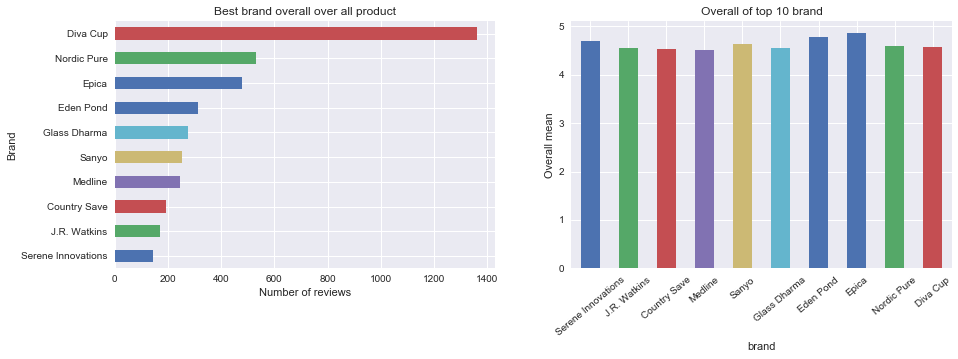

In [123]:
plotBar(topH)

**Patio Law and Garden**

In [109]:
patio = spark.read.parquet("PatioLawnGarden_joined.parquet")
patio = patio.toPandas()

In [124]:
# Only groupby brand and do not look at id
top_patio = patio.groupby('brand').agg(['count','mean'])

# Add the number of reviews
top_patio['nb reviews'] = top_patio[('overall','count')]

# Clean
#top_patio = top_patio.drop(columns=[('price','count'),('overall','count'),('salesRank','count'),'unixReviewTime'])
top_patio = top_patio.drop(columns=[('price','count'),('overall','count'),('salesRank','count')])

# Compute the overall mean round
top_patio['round reviews'] = top_patio[('overall','mean')].round()

# Keep the 10 best brands
topP = top_patio.sort_values(by=['round reviews','nb reviews'], ascending=False).head(10)
topP = topP.sort_values(by=['nb reviews'], ascending=True);

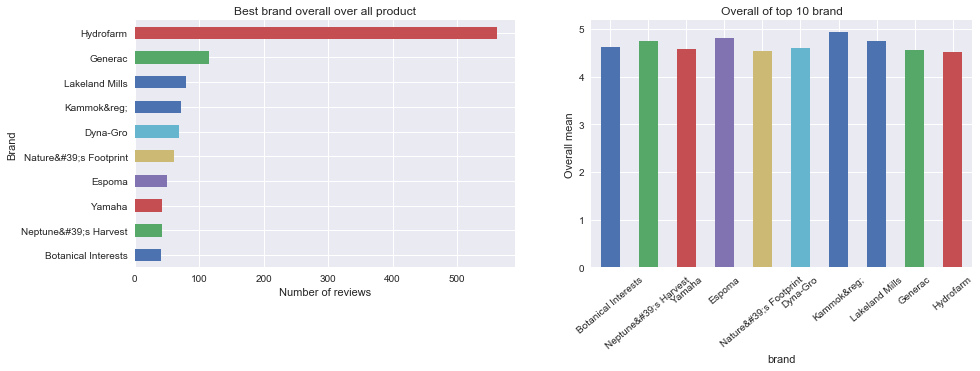

In [125]:
plotBar(topP)

**Books**

In [115]:
books = spark.read.parquet("Books_joined.parquet")
books = books.toPandas()

In [ ]:
# Only groupby brand and do not look at id
top_books = books.groupby('brand').agg(['count','mean'])

# Add the number of reviews
top_books['nb reviews'] = top_books[('overall','count')]

# Clean
top_books = top_books.drop(columns=[('price','count'),('overall','count'),('salesRank','count'),'unixReviewTime'])

# Compute the overall mean round
top_books['round reviews'] = top_books[('overall','mean')].round()

# Keep the 10 best brands
topB = top_books.sort_values(by=['round reviews','nb reviews'], ascending=False).head(10)
topB = topB.sort_values(by=['nb reviews'], ascending=True);

In [ ]:
plotBar(topB)

**Home and Kitchen**

In [126]:
home = spark.read.parquet("Home_and_Kitchen_joined.parquet")
home = home.toPandas()

In [127]:
# Only groupby brand and do not look at id
top_home = home.groupby('brand').agg(['count','mean'])

# Add the number of reviews
top_home['nb reviews'] = top_home[('overall','count')]

# Clean
#top_home = top_home.drop(columns=[('price','count'),('overall','count'),('salesRank','count'),'unixReviewTime'])
top_home = top_home.drop(columns=[('price','count'),('overall','count'),('salesRank','count')])

# Compute the overall mean round
top_home['round reviews'] = top_home[('overall','mean')].round()

# Keep the 10 best brands
topHome = top_home.sort_values(by=['round reviews','nb reviews'], ascending=False).head(10)
topHome = topHome.sort_values(by=['nb reviews'], ascending=True);

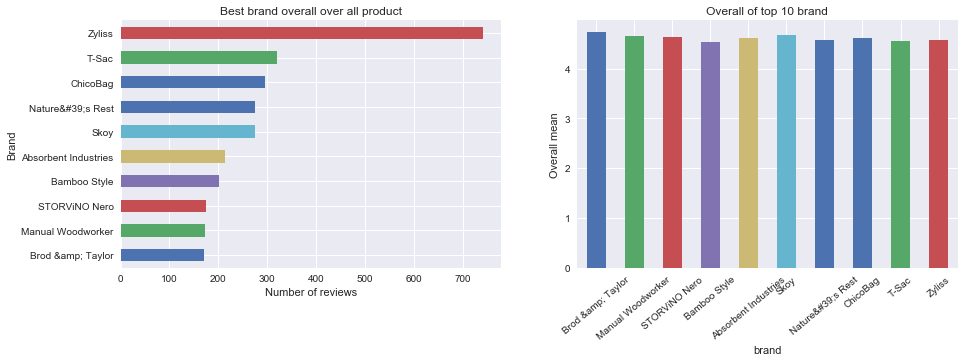

In [128]:
plotBar(topHome)

---
<a id='section9'></a>
## **9)** Mr/Mrs Ecofriendly


Grocery

In [30]:
grocery_top_reviewer =  grocery_food_review_product_join.rdd.map(lambda r: [r[10],1]) \
            .reduceByKey(lambda a,b: a+b)

grocery_top_reviewer_df = spark.createDataFrame(grocery_top_reviewer)

grocery_top_reviewer_pd = grocery_top_reviewer_df.toPandas()
grocery_top_reviewer_pd.columns= ['reviewerID','occurences_grocery']

Healthcare

In [23]:
healthcare_top_reviewer =  healthcare_review_product_join.rdd.map(lambda r: [r[10],1]) \
            .reduceByKey(lambda a,b: a+b)

healthcare_top_reviewer_df = spark.createDataFrame(healthcare_top_reviewer)

healthcare_top_reviewer_pd = healthcare_top_reviewer_df.toPandas()
healthcare_top_reviewer_pd.columns= ['reviewerID','occurences_healthcare']

top_reviewer_merged = pd.merge(grocery_top_reviewer_pd,healthcare_top_reviewer_pd, on='reviewerID',how='outer')

Garden

In [53]:
garden_top_reviewer =  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[10],1]) \
            .reduceByKey(lambda a,b: a+b)

garden_top_reviewer_df = spark.createDataFrame(garden_top_reviewer)

garden_top_reviewer_pd = garden_top_reviewer_df.toPandas()
garden_top_reviewer_pd.columns= ['reviewerID','occurences_garden']

top_reviewer_merged = pd.merge(top_reviewer_merged,garden_top_reviewer_pd, on='reviewerID',how='outer')

Home Kitchen

In [58]:
home_top_reviewer =  home_review_product_join.rdd.map(lambda r: [r[10],1]) \
            .reduceByKey(lambda a,b: a+b)

home_top_reviewer_df = spark.createDataFrame(home_top_reviewer)

home_top_reviewer_pd = home_top_reviewer_df.toPandas()
home_top_reviewer_pd.columns= ['reviewerID','occurences_home']

Merged Occurences

In [63]:
top_reviewer_merged = pd.merge(top_reviewer_merged,home_top_reviewer_pd, on='reviewerID',how='outer')
top_reviewer_merged = top_reviewer_merged.fillna(0)
top_reviewer_merged['sum'] = top_reviewer_merged.sum(axis=1)

In [103]:
top_reviewer_merged.sort_values('sum', ascending=False).head(5)

,reviewerID,occurences_grocery,occurences_healthcare,occurences_garden,occurences_home,sum
4154,A2OWR2PL3DLWS4,12.0,0.0,0.0,9.0,21.0
5454,A36MP37DITBU6F,9.0,3.0,0.0,3.0,15.0
1387,A1UQBFCERIP7VJ,4.0,6.0,1.0,4.0,15.0
3898,A2NYK9KWFMJV4Y,4.0,0.0,1.0,10.0,15.0
10450,A1LZJZIHUPLDV4,15.0,0.0,0.0,0.0,15.0


So the Mr/Mrs Ecofriendly has reviewed 21 ecofriendly products, mostly in the grocery and in the home categories. 
Let's reveal his name ! 

In [130]:
reviews_grocery = spark.read.json("data/reviews_Grocery_and_Gourmet_Food.json")

In [147]:
get_names =  reviews_grocery.rdd.filter(lambda r: (r[5] == 'A2OWR2PL3DLWS4'))

In [148]:
get_names.take(1)

[Row(asin='B0000VJA5K', helpful=[3, 4], overall=5.0, reviewText="I bought mine at a store- so I knew it was honey FLAVORED with lavender essence. I read the ingredients- which are also listed right here on Amazon.  If you like that lavender flavor you will love this.  It's quite clearly supposed to taste like lavender, NOT be a lavender honey derived from lavender flowers.  IT's quite unfair for that negative reviewer to get mad at this product because he or she did not read the ingredients.  This is absolute perfection for what it is- and it's quite clearly listed in the ingredients what this is.  So if that sounds good to you, that is what you will get.  I eat mine on toast and pancakes and cheese.  I think it would be lovely over ice cream, cream puffs and profiteroles, but I have not tried that yet.", reviewTime='01 3, 2010', reviewerID='A2OWR2PL3DLWS4', reviewerName='Love to Cook', summary='Wonderful', unixReviewTime=1262476800)]

And the name of the winner is... '__Love to Cook__'

Strange name but we can see that this reviewer loves indeed to cook, as there is 12 ecofriendly products reviews in the category grocery food and after analysis the 9 ecofiendly products from the category Home and Kitchen are related to the cooking.

As in the above review sample of this winner, this person is taking care of the natural taste, without pesticides of the products and the original/organic aspect. 

After analyzing the other top ecofriendly reviewers we find below their names. We can relate their interest in their reviews about the environmental, organic and natural aspects of the products.

- reviewerName 1 = 'Love to Cook'
- reviewerName 2 = 'Enchanted  In  Dixie "Enchanted"'
- reviewerName 3 = 'Margaret Picky'
- reviewerName 4 = 'Mike Tarrani "Jazz Drummer"'
- reviewerName 5 = 'vegancompassion "anattanupassana"'

The 5th top reviewer (A1LZJZIHUPLDV4) has a 'funny name' : '__vegancompassion__', and seems to be dedicated to the grocery food section.
Let's observe his type of comment to know a bit more about this person.

In [149]:
get_names =  reviews_grocery.rdd.filter(lambda r: (r[5] == 'A1LZJZIHUPLDV4'))

In [150]:
get_names.take(1)

[Row(asin='B0006MUF6G', helpful=[4, 5], overall=5.0, reviewText='Vegan. All natural. Convenient foil package. Heat & serve. Great with tortillas or over rice. Made near Pune, India but brings back happy memories of Kolkata (Calcutta.) Amazing to be able to buy the "real thing" in America from Amazon.Tasty Bite Entr&eacute;e, Bombay Potatoes, 10-Ounce Boxes (Pack of 12)andTasty Bite Yellow Curry Vegetables & Jasmine Rice, 12-Ounce Boxes (Pack of 6)are also very good. This review is for those out there for whom this makes a difference. Check out my other reviews and listmania for more great choices. Thank you.', reviewTime='06 17, 2007', reviewerID='A1LZJZIHUPLDV4', reviewerName='vegancompassion "anattanupassana"', summary='Vegan Natural Kosher Choice', unixReviewTime=1182038400)]

Again this one, as previously said, is taking care of the natural aspect and the package, and wants to advice people about this ecofriendly aspect 'for whom this makes a difference'.